In [1]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'

%matplotlib inline

import csv
import re
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import warnings
from csv_reader import read_csv
from aux import set_smallest_n_zero
from disp import set_font_size
from copy import deepcopy as copy
from analysis_tools import *
from pathlib import Path
from csv_reader import read_csv
from csv_writer import write_csv

new_rc_params = {
    'text.usetex': False,
    "svg.fonttype": 'none'
}
matplotlib.rcParams.update(new_rc_params)

plt.rcParams['font.size'] = 15
plt.rcParams['axes.linewidth'] = 3.0

warnings.filterwarnings('ignore')

rule_names = [ # Define labels for all rules to be run during simulations
    r'Const',
    r'$y$',
    r'$x$',
    r'$x \, y$',
    r'$y_{int}$',
    r'$x \, y_{int}$',
    r'$x_{int}$',
    r'$x_{int} \, y$',
    r'$y_{int} \, y$',
    r'$x_{int} \, x$',

    r'$w$',
    r'$w \, y$',
    r'$w \, x$',
    r'$w \, x \, y$',
    r'$w y_{int}$',
    r'$w x \, y_{int}$',
    r'$w x_{int}$',
    r'$w x_{int} \, y$',
    r'$w y_{int} \, y$',
    r'$w x_{int} \, x$',
]

time_constants = [
    r'$\tau \, y_{int}$',
    r'$\tau \, x \, y_{int}$',
    r'$\tau \, x_{int}$',
    r'$\tau \, x_{int} \, y$',
    r'$\tau \, y_{int} \, y$',
    r'$\tau \, x_{int} \, x$',
    
    r'$\tau \, w y_{int}$',
    r'$\tau \, w x \, y_{int}$',
    r'$\tau \, w x_{int}$',
    r'$\tau \, w x_{int} \, y$',
    r'$\tau \, w y_{int} \, y$',
    r'$\tau \, w x_{int} \, x$',
]

general_rule_names = copy(rule_names)

rule_names = [
    [r'$E \rightarrow E$ ' + r_name for r_name in rule_names],
    [r'$E \rightarrow I$ ' + r_name for r_name in rule_names],
    [r'$I \rightarrow E$ ' + r_name for r_name in rule_names],
]
rule_names = np.array(rule_names).flatten()

In [2]:
def plot_opt_run(file_name, n_plasticity_coefs, n_time_constants, batch_size, start=0, yscale=None, n_categories=1, loss_yscale=None):
    figure_path = f'./figures/{file_name}'
    Path(figure_path).mkdir(parents=True, exist_ok=True)
    
    train_data_path = f'./sims_out/{file_name}/train_data.csv'
    test_data_path = f'./sims_out/{file_name}/test_data.csv'
    
    df_train = read_csv(train_data_path, read_header=False)
    df_test = read_csv(test_data_path, read_header=False)
    
    # plot synaptic effects per rule
    scale = 2
    fig, axs = plt.subplots(1, 2, figsize=(6 * scale, 2.5 * scale))
    format_axs(axs)
    
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Rule coefficient')
    if yscale is not None:
        axs[0].set_ylim(0, yscale)
    
    syn_effect_start = 2 + batch_size + n_plasticity_coefs + n_time_constants
    syn_effect_end = 2 + batch_size + n_plasticity_coefs + n_time_constants + n_plasticity_coefs
    x = np.arange(df_train.shape[0])[start:]
    x_test = np.arange(df_test.shape[0])[start:]
    losses = df_train[df_train.columns[1]][start:]
    x_mins = []

    for i in range(0, len(x), 15):
        x_mins.append(np.argmin(losses[i:i+15]) + i)
        
    x_mins = np.array(x_mins)
    x_best_min = np.argmin(losses)
    
    x_test = df_test[df_test.columns[0]]
    losses_test = df_test[df_test.columns[1]]
    
    final_syn_effects = []
    final_coefs = []
    
    for i in range(syn_effect_start, syn_effect_end):
#         axs[0].plot(df_train[df_train.columns[0]][start:][x_mins], df_train[df_train.columns[i]][start:][x_mins])
        
        final_syn_effects.append(df_train[df_train.columns[i]][start:][x_best_min])
        
    final_syn_effects = np.array(final_syn_effects)
        
    axs[1].plot(x_mins[1:-1], losses[x_mins[1:-1]], color='black')
    axs[1].plot(x_test, losses_test, color='blue')
    axs[1].set_ylim(0, 5000)
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epochs')
        
    plasticity_coefs_start = 2 + batch_size
    plasticity_coefs_end = 2 + batch_size + n_plasticity_coefs + n_time_constants
    
    cmap = matplotlib.cm.get_cmap('nipy_spectral')
    colors = [cmap(x) for x in np.linspace(0, 1, n_plasticity_coefs + n_time_constants)]
    np.random.shuffle(colors)
    
    for i in range(plasticity_coefs_start, plasticity_coefs_end):
        axs[0].plot(df_train[df_train.columns[0]][start:][x_mins], df_train[df_train.columns[i]][start:][x_mins], color=colors[i - plasticity_coefs_start])
        final_coefs.append(df_train[df_train.columns[i]][start:][x_best_min])
        
    set_font_size(axs[0], 20)
    set_font_size(axs[1], 20)
    fig.tight_layout()
    fig.savefig(os.path.join(figure_path, 'loss_and_coef_evo.png'))
    fig.savefig(os.path.join(figure_path, 'loss_and_coef_evo.svg'))
    
    final_coefs = np.array(final_coefs)
    
    # plot the synaptic effects of each plasticity rule (unsorted by size)
    scale = 2
    fig, axs = plt.subplots(n_categories, 1, figsize=(6 * scale, 3 * n_categories * scale))
    if n_categories == 1:
        axs = [axs]
    
    partial_rules_len = int(len(final_syn_effects) / n_categories)

    for l in range(n_categories):
        format_axs(axs[l])
        x = np.arange(partial_rules_len)
        y = final_syn_effects[l * partial_rules_len: (l+1) * partial_rules_len]
        colors = np.where(final_coefs[l * partial_rules_len: (l+1) * partial_rules_len] > 0, 'green', 'red')
#         y_err = final_syn_effect_stds[l * partial_rules_len: (l+1) * partial_rules_len]
        axs[l].bar(x, y, color=colors, alpha=0.3)
        axs[l].set_xticks(np.arange(partial_rules_len))
        axs[l].set_xticklabels(rule_names[l * partial_rules_len: (l+1) * partial_rules_len], rotation=60, ha='right')
        axs[l].set_ylabel('Absolute synaptic change')
        axs[l].set_xlim(-1, partial_rules_len)    
    
        set_font_size(axs[l], 20)
        

    fig.tight_layout()
    fig.savefig(os.path.join(figure_path, 'final_syn_change.png'))
    fig.savefig(os.path.join(figure_path, 'final_syn_change.svg'))
    
    # plot entropy of synaptic change per rule against epochs
    scale = 2
    fig, axs = plt.subplots(1, 1, figsize=(6 * scale, 2.5 * scale))
    format_axs(axs)
    
    axs.set_xlabel('Epochs')
    axs.set_ylabel('Entropy')
    
    entropy = []
    for i in x_mins[1:]:
        syn_effects_i = np.array(df_train.iloc[i][syn_effect_start:syn_effect_end])
        entropy.append(calc_entropy(syn_effects_i))
        
    entropy = np.array(entropy)
    
    axs.plot(x_mins[1:], entropy, c='green')
    
    scale = 2
    fig2, axs2 = plt.subplots(1, 1, figsize=(2.5 * scale, 6 * scale))
#     format_axs(axs2)

    x = np.concatenate([np.arange(n_plasticity_coefs), np.arange(n_plasticity_coefs + 1, n_plasticity_coefs + 1 + n_time_constants)])
    y = np.array(final_coefs)
    axs2.barh(x, y, alpha=0.5, color=['#1128d4'] * n_plasticity_coefs + ['#6528de'] * n_time_constants)
#     axs2.errorbar(x, y, yerr=final_plasticity_coef_stds, ls='none', color='black')
    
    axs2.set_ylim(len(x) + 1, -1)
    axs2.set_yticks(np.arange(len(x) + 1))
    tick_labels = list(general_rule_names[:len(x)]) + [''] + time_constants
    axs2.set_yticklabels(tick_labels, rotation=0)
    axs2.set_xlabel('Duration (s)')
    axs2_twin = axs2.twiny()
    axs2_twin.set_xlabel('Coefficient')
    
    axs2.spines['right'].set_visible(False)
    axs2_twin.spines['right'].set_visible(False)
    
    x_lim = np.max(np.abs(y)) * 1.02
    
    axs2.set_xlim(-x_lim, x_lim)
    plt.locator_params(axis='x', nbins=3)
    axs2_twin.set_xlim(-x_lim, x_lim)
    plt.locator_params(axis='x', nbins=3)
    
    set_font_size(axs2, 20)
    set_font_size(axs2_twin, 20)

    return np.array(final_syn_effects), np.array(final_coefs), losses[x_best_min]

In [4]:
def plot_all_opt_runs(all_files, n_plasticity_coefs, n_time_constants, batch_size, n_categories=3, l_thresh=1000, name='default'):
    figure_path = f'./figures/{name}'
    Path(figure_path).mkdir(parents=True, exist_ok=True)
    
    final_syn_effects = []
    final_plasticity_coefs = []

    for f in all_files:
        syn_effects_for_f, plasticity_coefs_for_f, best_loss_for_f = plot_opt_run(f, n_plasticity_coefs, n_time_constants, batch_size, n_categories=n_categories)
        if best_loss_for_f < l_thresh:
            print(f'{f}')
            final_syn_effects.append(syn_effects_for_f)
            final_plasticity_coefs.append(plasticity_coefs_for_f)

    final_syn_effects = np.stack(final_syn_effects)
    final_syn_effect_means = np.mean(final_syn_effects, axis=0)
    final_syn_effect_stds = np.std(final_syn_effects, axis=0) / np.sqrt(final_syn_effects.shape[0])

    final_plasticity_coefs = np.stack(final_plasticity_coefs)
    final_plasticity_coef_means = np.mean(final_plasticity_coefs, axis=0)
    final_plasticity_coef_stds = np.std(final_plasticity_coefs, axis=0) / np.sqrt(final_plasticity_coefs.shape[0])

    print(final_plasticity_coef_means)

    # plot the synaptic effects of each plasticity rule (unsorted by size)
    scale = 2
    fig, axs = plt.subplots(n_categories, 1, figsize=(6 * scale, 3 * n_categories * scale))
    if n_categories == 1:
        axs = [axs]
    partial_rules_len = int(len(final_syn_effect_means) / n_categories)

    for l in range(n_categories):
        format_axs(axs[l])
        x = np.arange(partial_rules_len)
        y = final_syn_effect_means[l * partial_rules_len: (l+1) * partial_rules_len]
        y_err = final_syn_effect_stds[l * partial_rules_len: (l+1) * partial_rules_len]
        colors = np.where(final_plasticity_coef_means[l * partial_rules_len: (l+1) * partial_rules_len] > 0, 'green', 'red')
        axs[l].bar(x, y, alpha=0.3, color=colors)
        axs[l].errorbar(x, y, yerr=y_err, ls='none', color='black')

        axs[l].set_xticks(np.arange(partial_rules_len))
        axs[l].set_xticklabels(rule_names[l * partial_rules_len: (l+1) * partial_rules_len], rotation=60, ha='right')
        axs[l].set_ylabel('Absolute synaptic change')
        axs[l].set_xlim(-1, partial_rules_len)
        
        set_font_size(axs[l], 20)

    fig.tight_layout()
    fig.savefig(os.path.join(figure_path, 'final_syn_change.png'))
    fig.savefig(os.path.join(figure_path, 'final_syn_change.svg'))

    # plot the synaptic effects of each plasticity rule as scatter plot
    scale = 2
    fig, axs = plt.subplots(3, 1, figsize=(6 * scale, 5.5 * scale))

    cmap = matplotlib.cm.get_cmap('nipy_spectral')
    colors = [cmap(x) for x in np.linspace(0, 0.55, final_syn_effects.shape[1])]
    np.random.shuffle(colors)

    max_val = 0
    for i in range(n_categories):
        for j in range(partial_rules_len):
            x = i * partial_rules_len + j
            y = final_syn_effects[:, x]
            axs[i].scatter(j * np.ones(final_syn_effects.shape[0]) + np.random.normal(0, 0.15, final_syn_effects.shape[0]), y, s=30, facecolors='none', edgecolors=colors[j], marker='o')

            if np.max(y) > max_val:
                max_val = np.max(y)
        axs[i].set_xlim(-1, partial_rules_len)
        if i < n_categories - 1:
            axs[i].set_xticks([])

    axs[2].set_xticklabels(general_rule_names, rotation=60)
    axs[2].set_xticks(np.arange(partial_rules_len))

    axs[1].set_ylabel('Absolute synaptic change')

    for i in range(n_categories):
        axs[i].set_ylim(0, max_val * 1.1)

    # plot covariance of synaptic changes due to each rule
    normed_syn_effect_means = final_syn_effect_means / np.sum(final_syn_effect_means)

    fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))
    format_axs(axs)
    syn_effect_cov_mat = np.cov(np.array(final_syn_effects).T)
    max_abs_val = np.max(np.abs(syn_effect_cov_mat))
    mappable = axs.matshow(syn_effect_cov_mat, cmap='bwr', vmin=-max_abs_val, vmax=max_abs_val)
    plt.colorbar(mappable)
    axs.set_xticks(np.arange(len(final_syn_effect_means)))
    axs.set_xticklabels(rule_names[:len(final_syn_effect_means)], rotation=60)
    axs.set_yticks(np.arange(len(final_syn_effect_means)))
    axs.set_yticklabels(rule_names[:len(final_syn_effect_means)], rotation=0)

    # plot the coefficients assigned to each plasticity rule (unsorted by size)
    scale = 2
    fig2, axs2 = plt.subplots(1, 1, figsize=(2.5 * scale, 6 * scale))
#     format_axs(axs2)

    x = np.arange(len(final_plasticity_coef_means))
    y = final_plasticity_coef_means
    axs2.barh(x, y, alpha=0.5, color=['#1128d4'] * n_plasticity_coefs + ['#6528de'] * n_time_constants)
#     axs2.errorbar(x, y, yerr=final_plasticity_coef_stds, ls='none', color='black')
    
    axs2.set_ylim(len(final_plasticity_coef_means), -1)
    axs2.set_yticks(np.arange(len(final_plasticity_coef_means)))
    tick_labels = list(general_rule_names[:len(final_syn_effect_means)]) + time_constants
    axs2.set_yticklabels(tick_labels, rotation=0)
    axs2.set_xlabel('Duration (s)')
    axs2_twin = axs2.twiny()
    axs2_twin.set_xlabel('Coefficient')
    
    axs2.spines['right'].set_visible(False)
    axs2_twin.spines['right'].set_visible(False)
    
    x_lim = np.max(np.abs(y)) * 1.05
    
    axs2.set_xlim(-x_lim, x_lim)
    axs2.set_xticks([])
    axs2.set_xticklabels([])
    axs2_twin.set_xlim(-x_lim, x_lim)
    
    set_font_size(axs2, 20)
    set_font_size(axs2_twin, 20)
    fig2.savefig(os.path.join(figure_path, 'coefs.png'))
    fig2.savefig(os.path.join(figure_path, 'coefs.svg'))

# Finding a minimal set of plasticity rules that supports self-organization of sequence generation

decoder_ee_rollback_rescaled_b_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_8000_2023-08-29_23:47:23.365282
decoder_ee_rollback_rescaled_b_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_8001_2023-08-29_23:48:26.168644
decoder_ee_rollback_rescaled_b_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_8002_2023-08-29_23:48:44.153583
decoder_ee_rollback_rescaled_b_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_8003_2023-08-29_23:49:09.077896
decoder_ee_rollback_rescaled_b_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_8004_2023-09-04_07:15:54.654105
decoder_ee_rollback_rescaled_b_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_8005_2023-12-05_17:47:42.563397
decoder_ee_rollback_rescaled_b_10_STD_EXPL_0.0

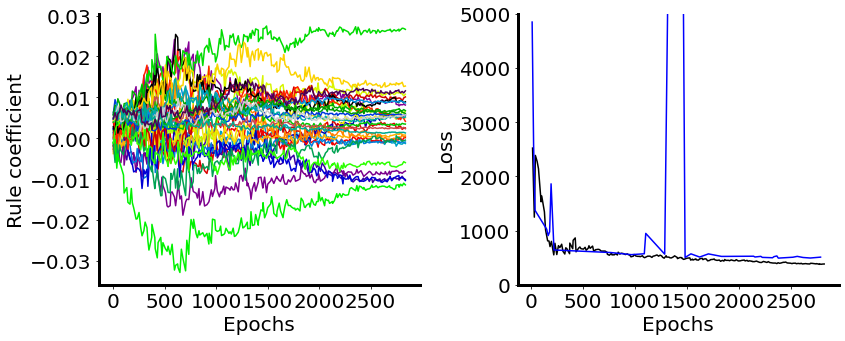

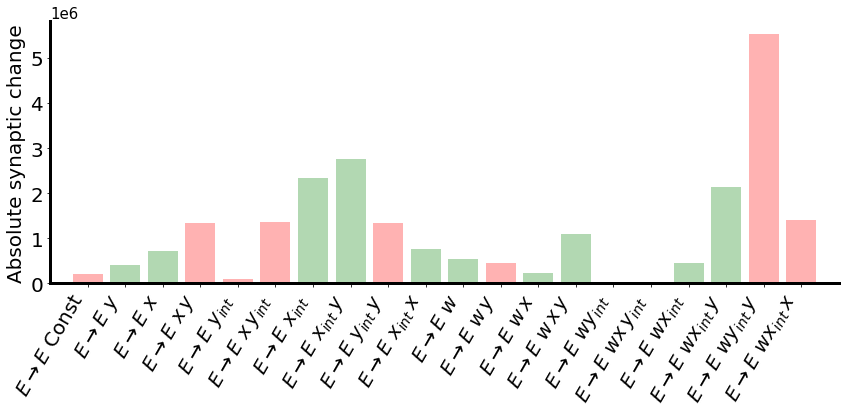

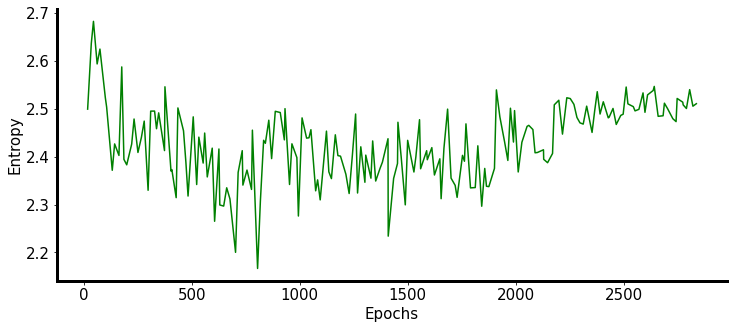

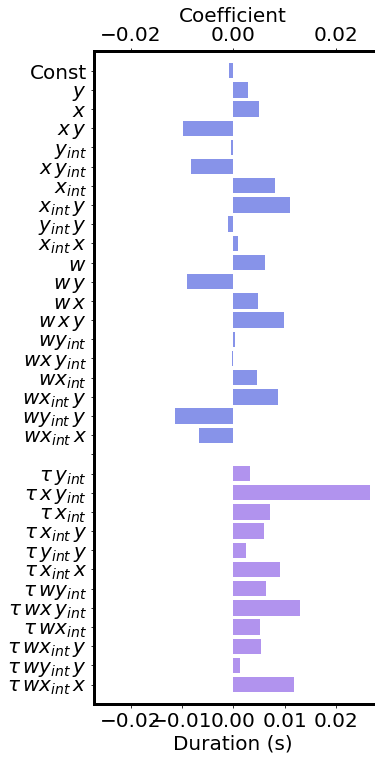

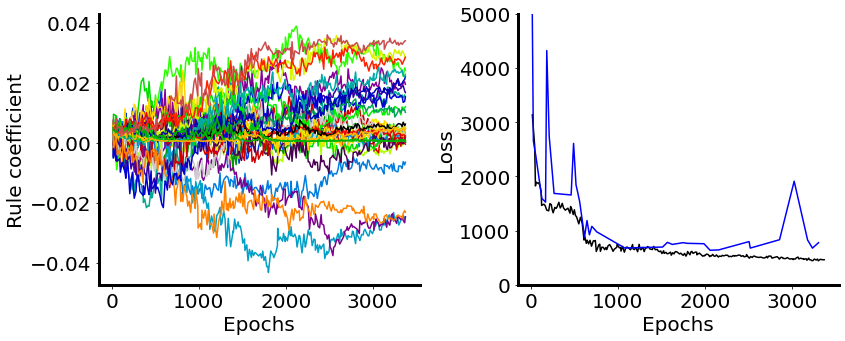

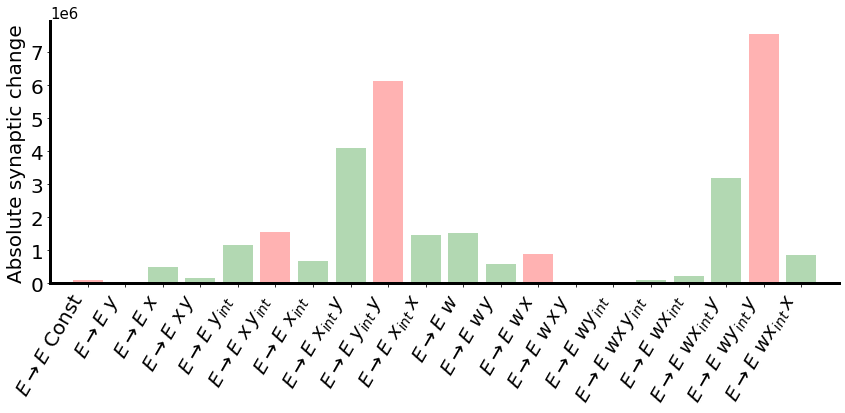

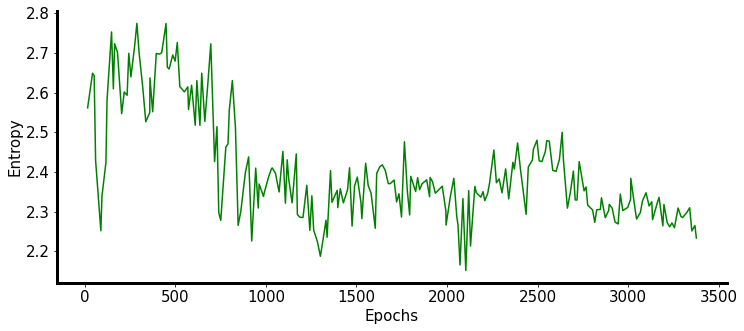

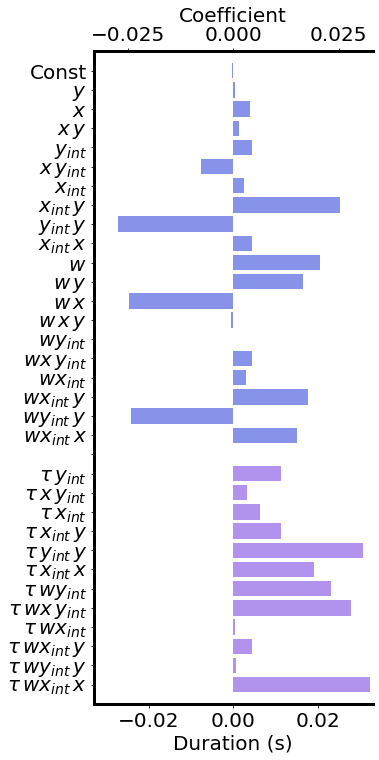

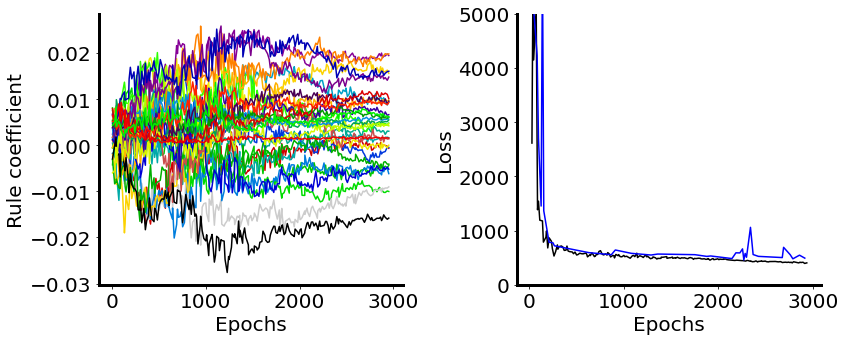

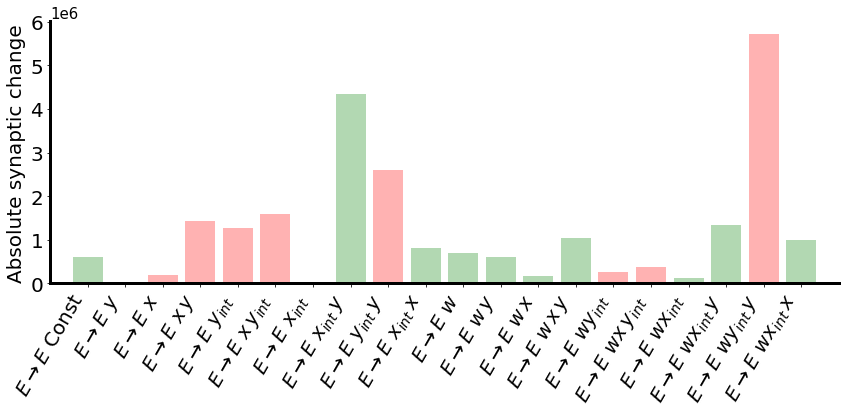

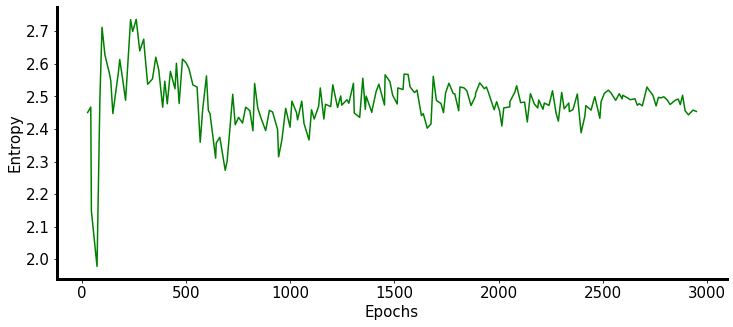

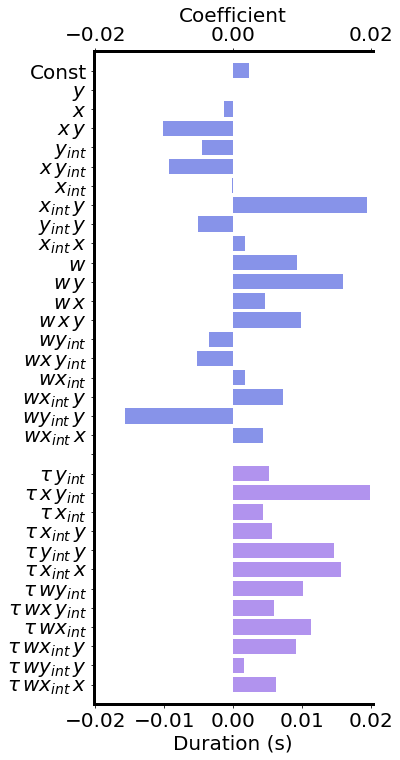

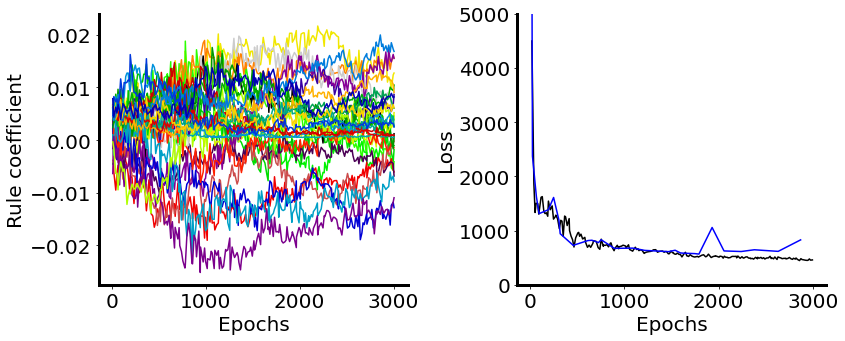

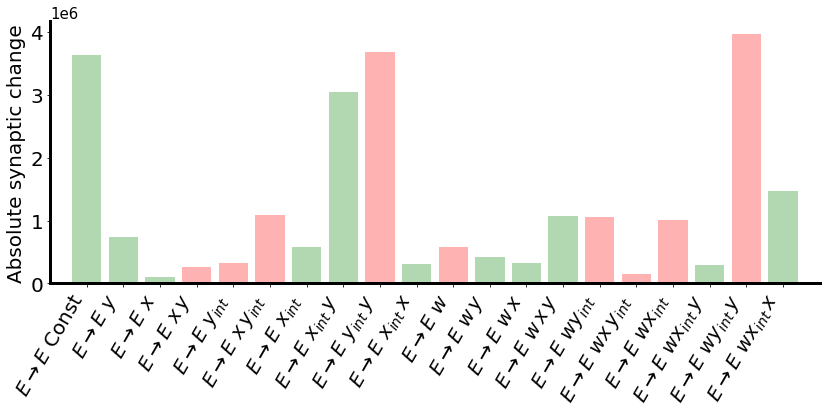

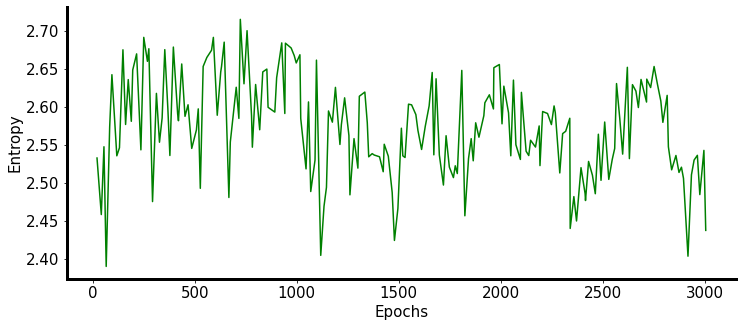

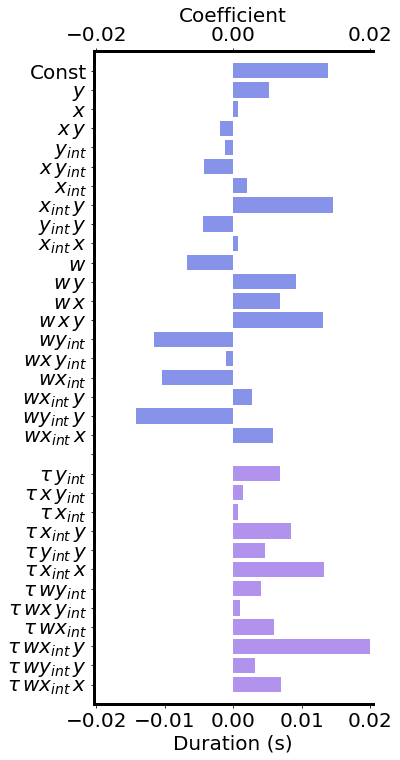

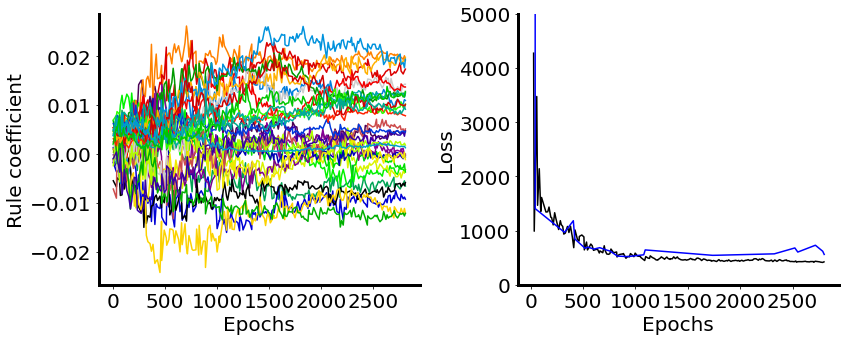

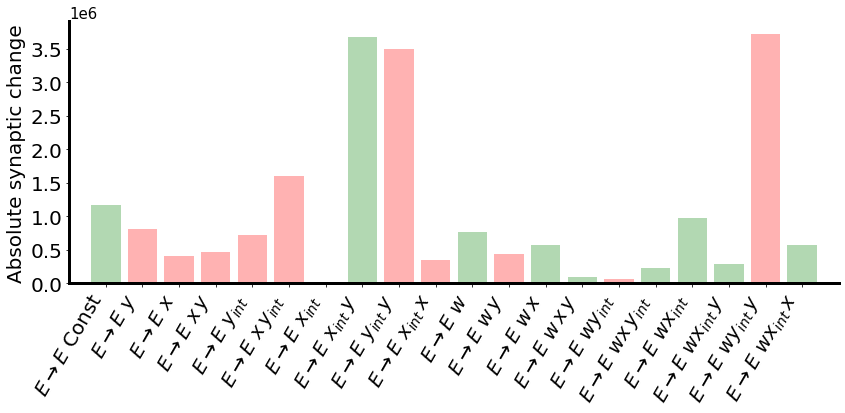

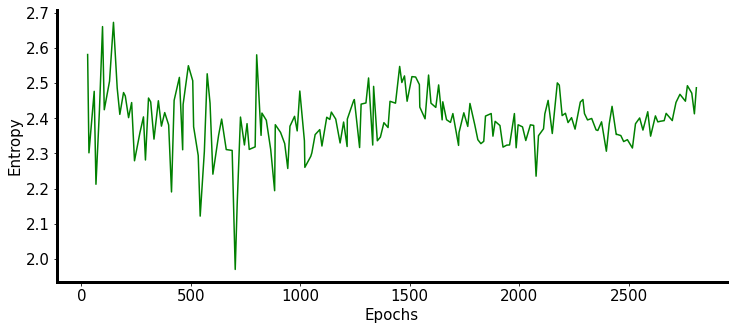

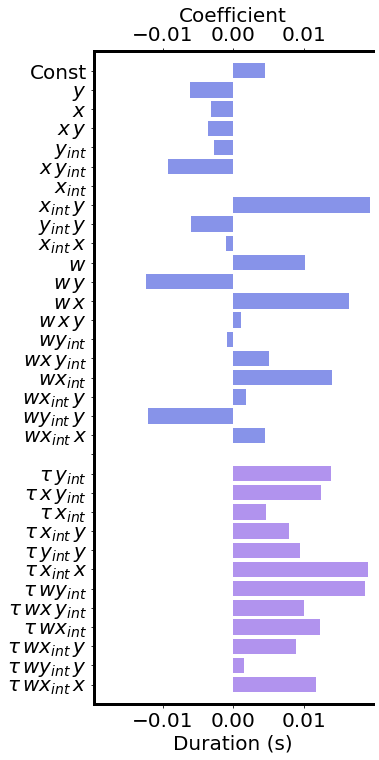

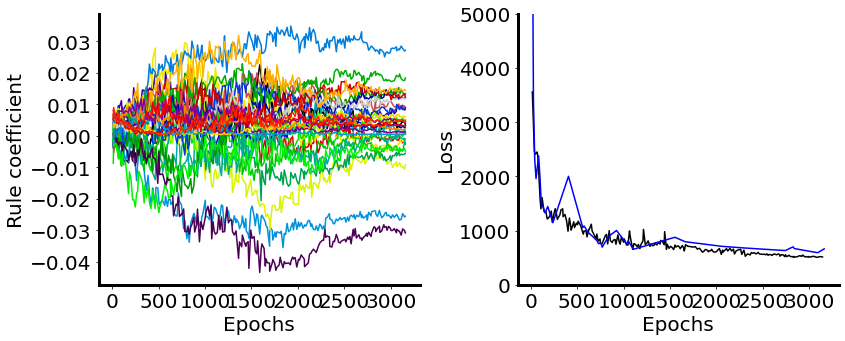

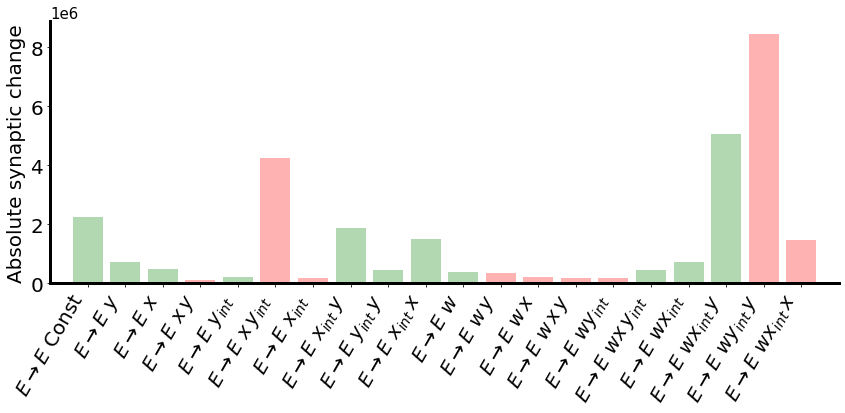

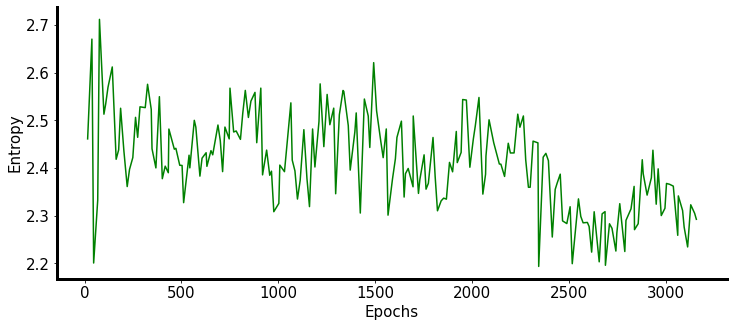

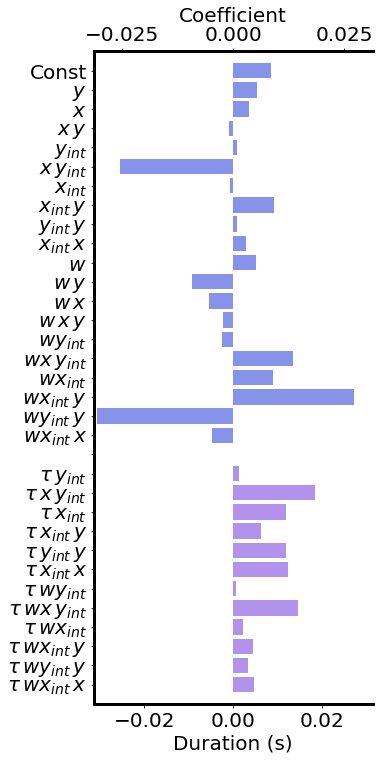

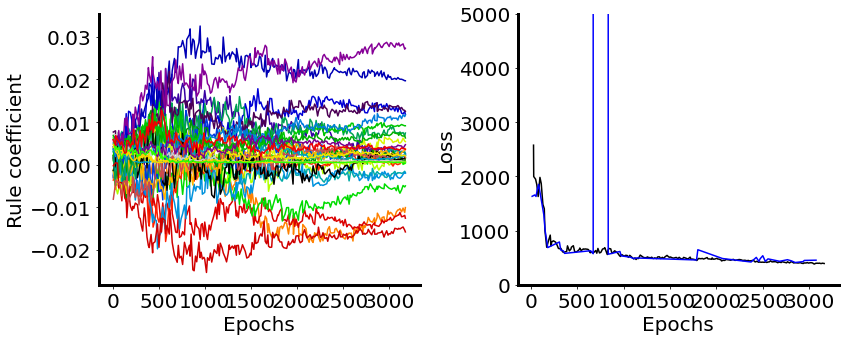

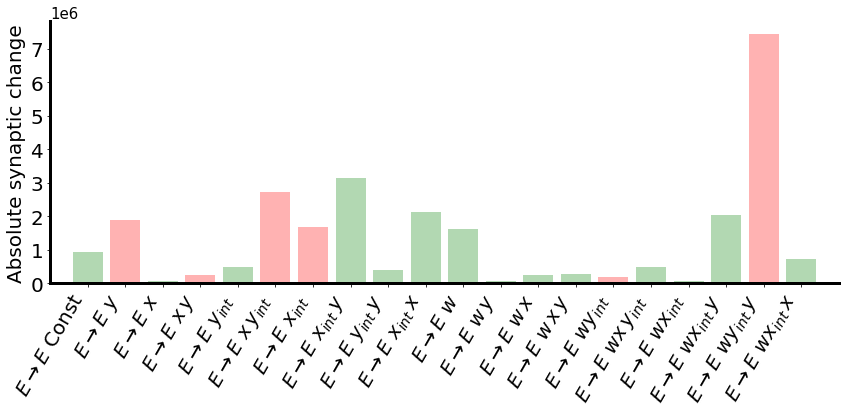

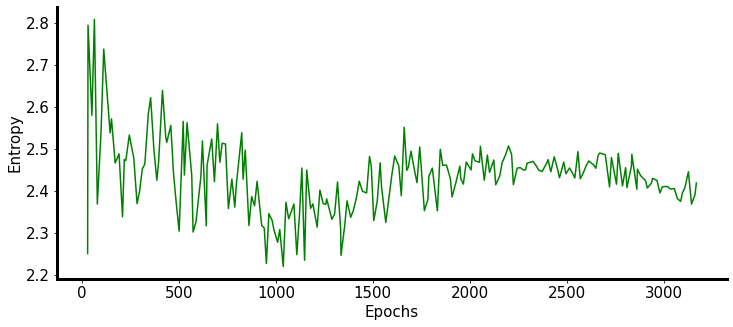

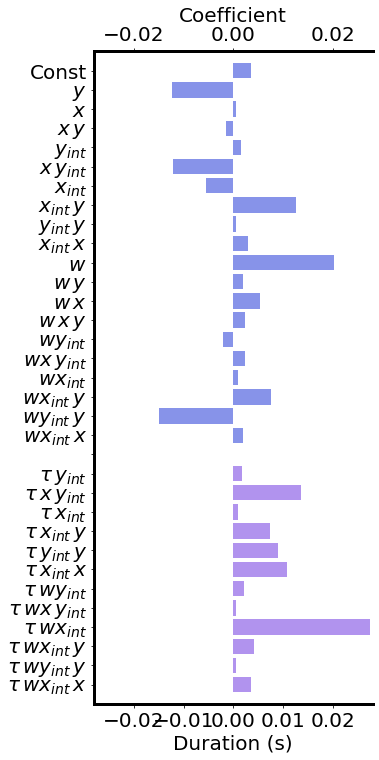

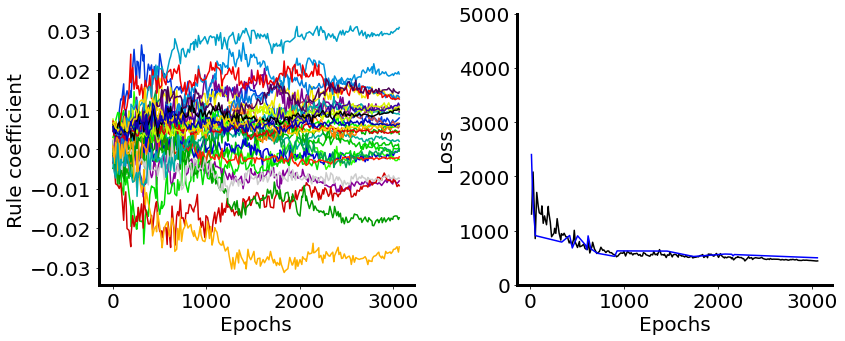

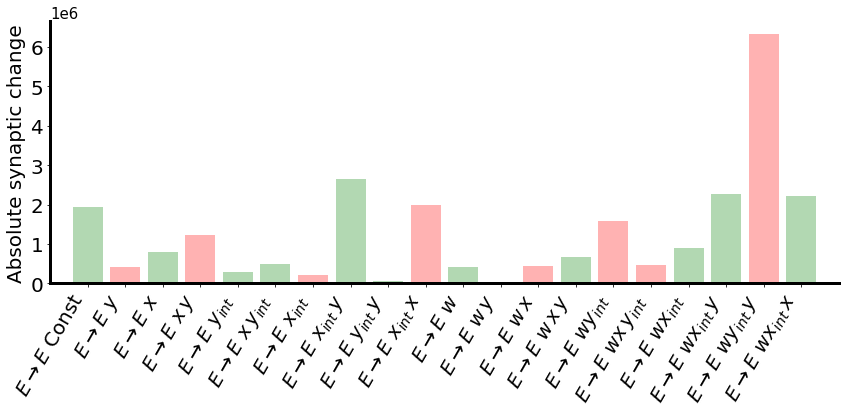

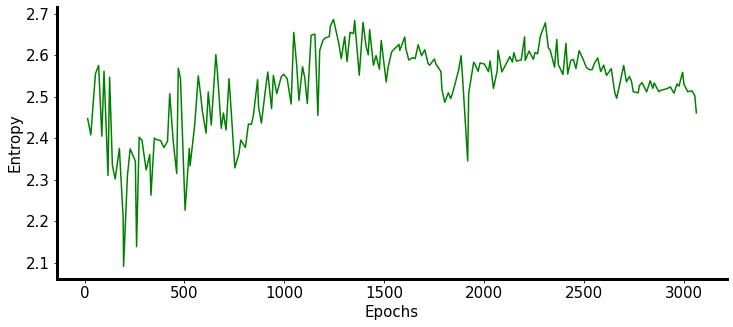

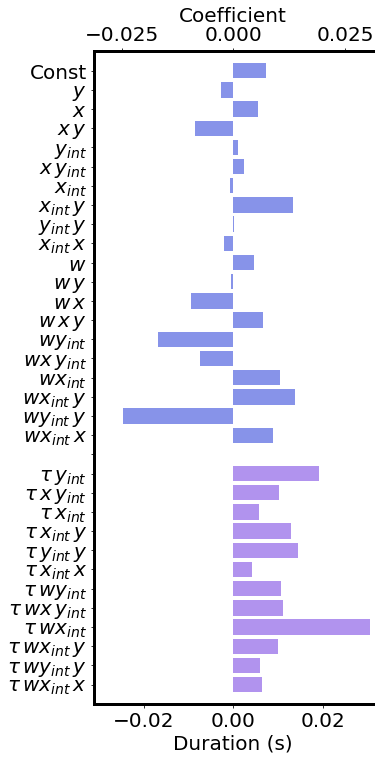

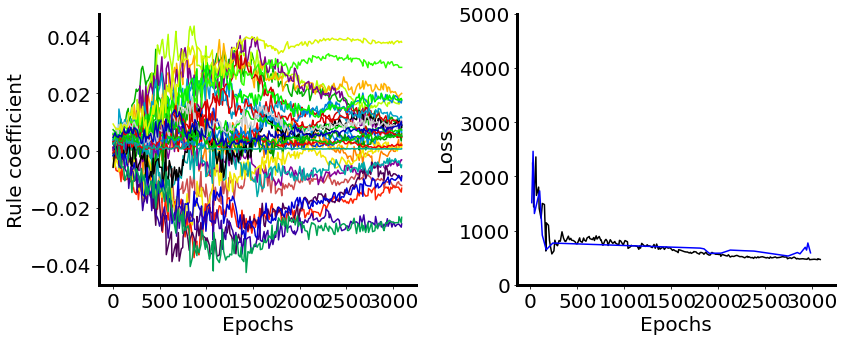

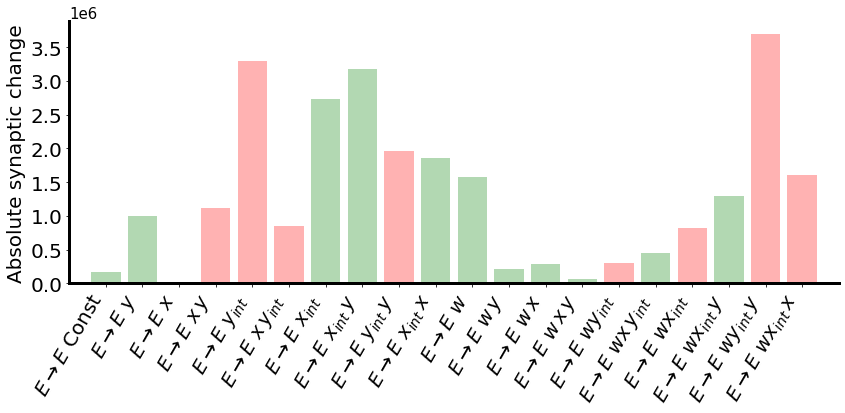

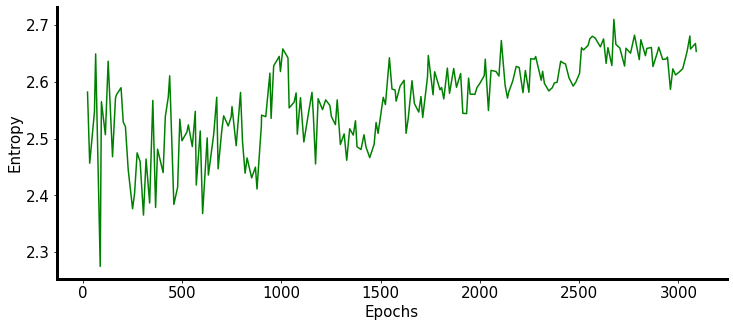

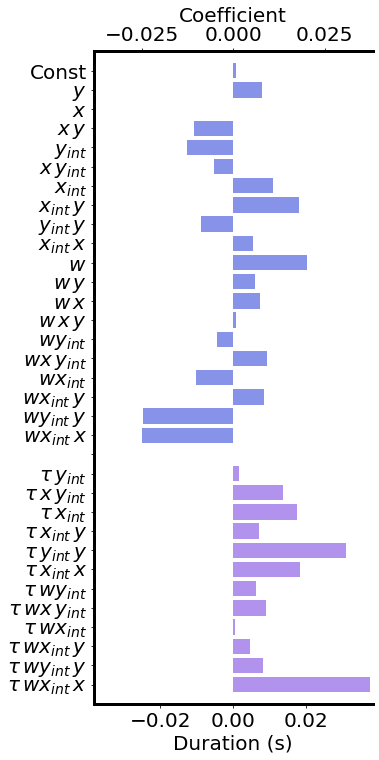

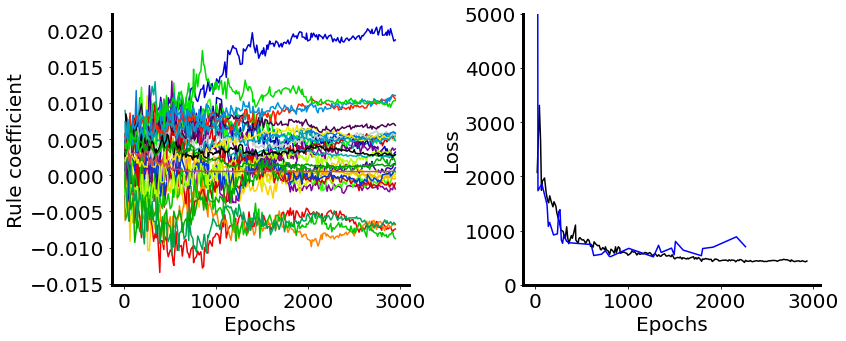

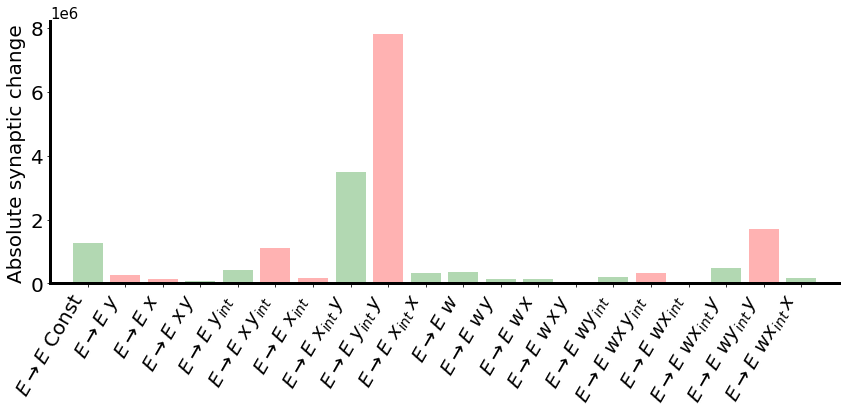

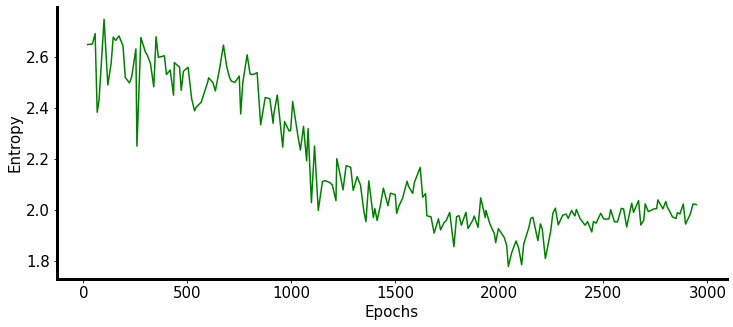

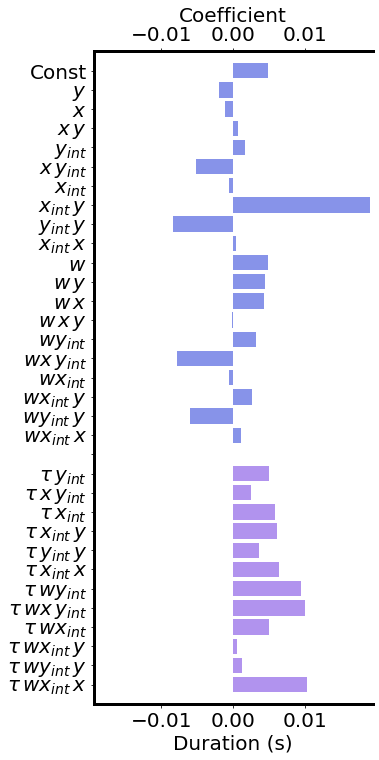

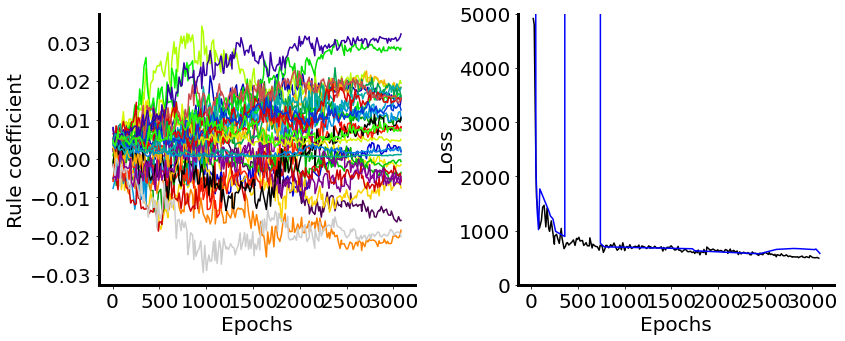

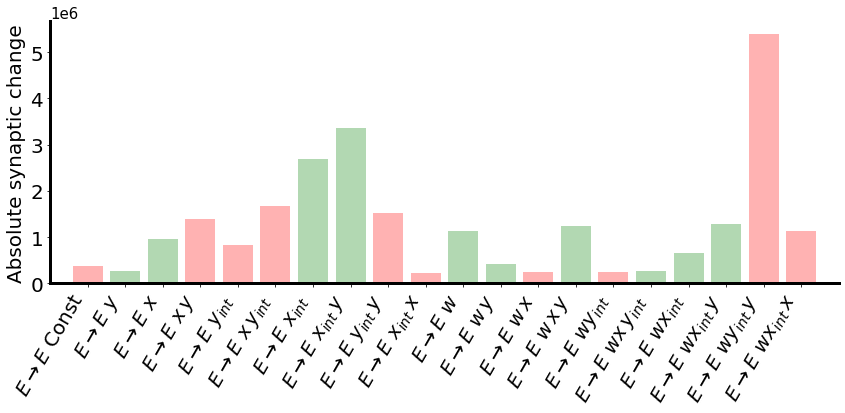

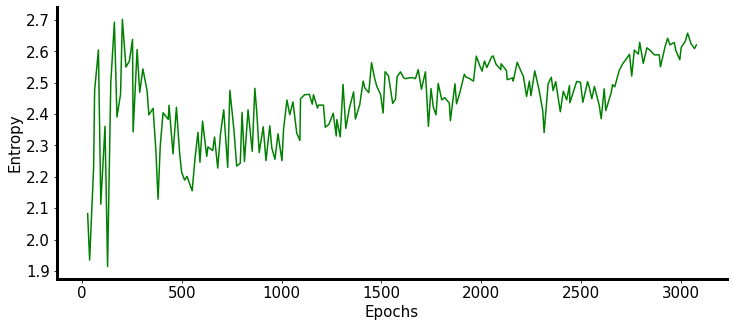

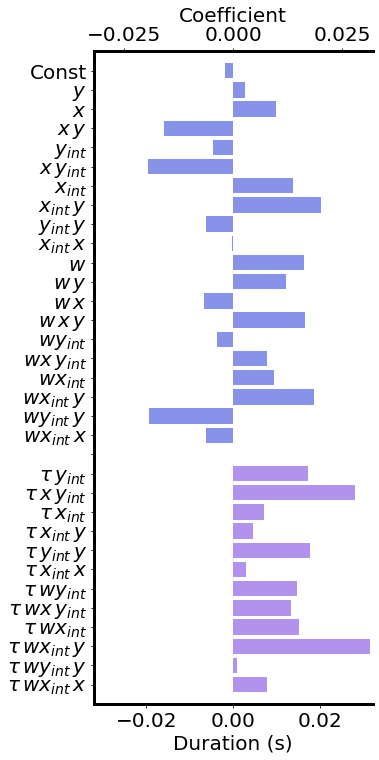

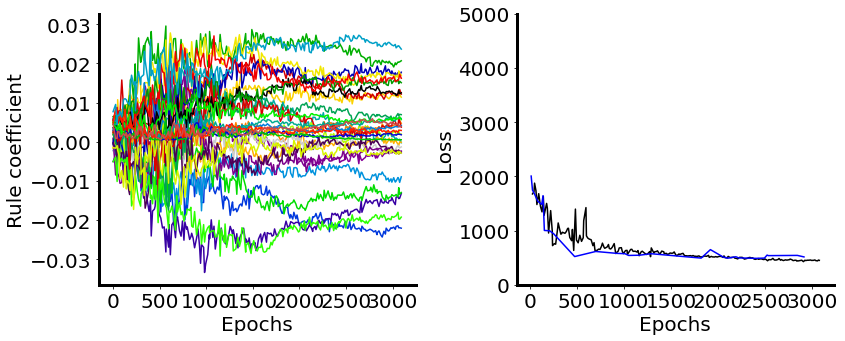

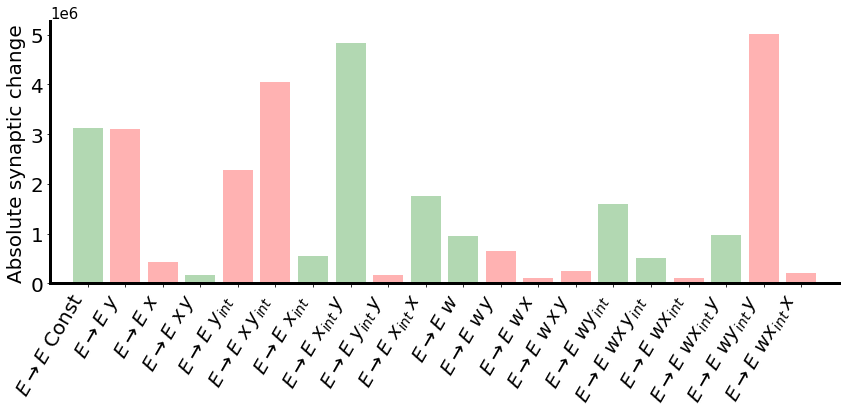

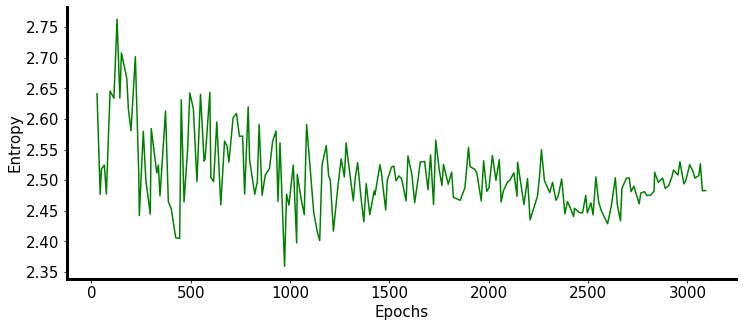

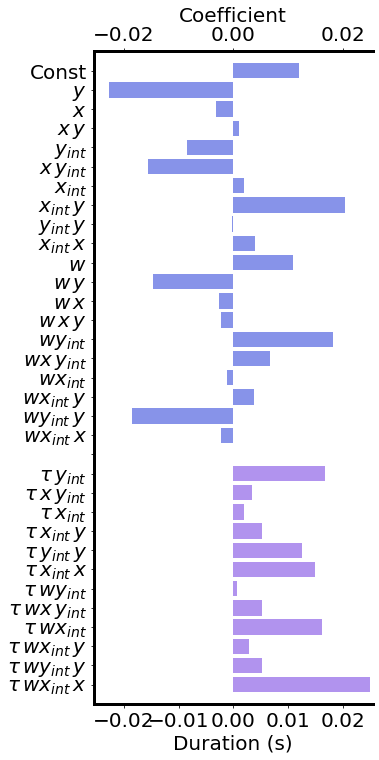

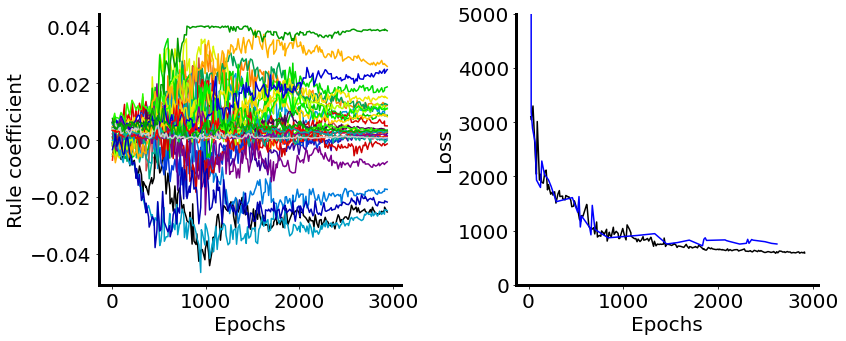

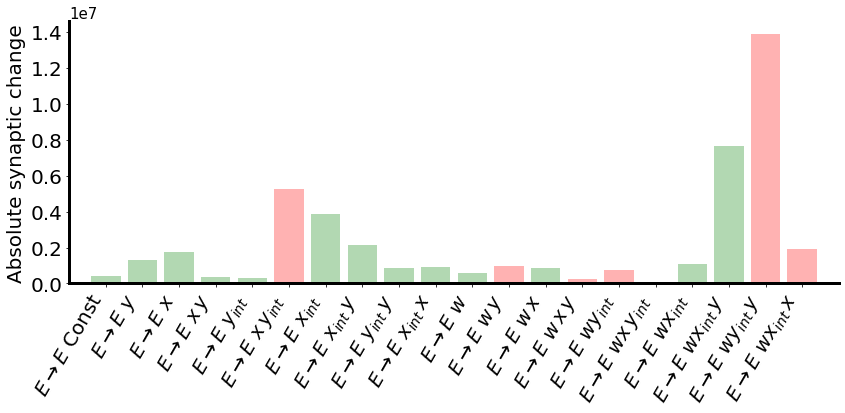

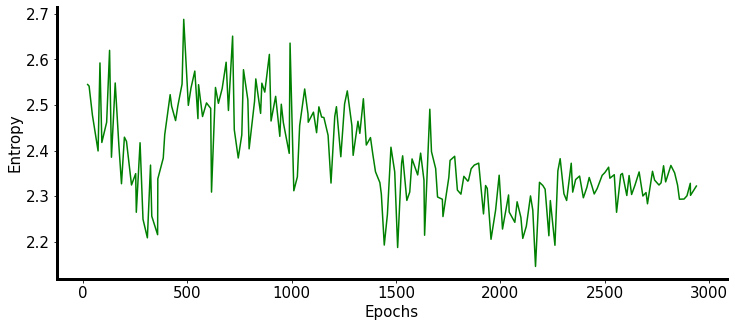

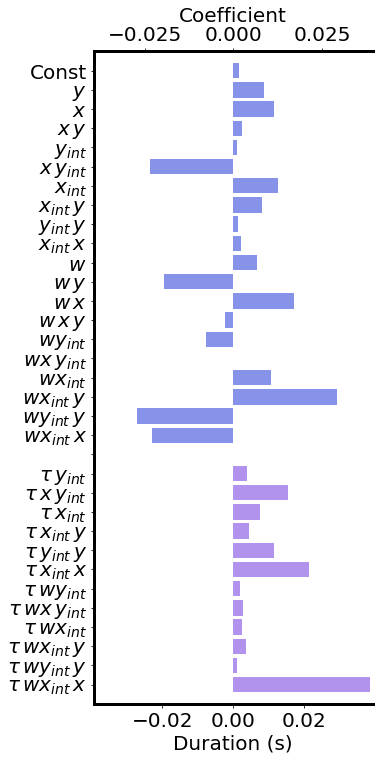

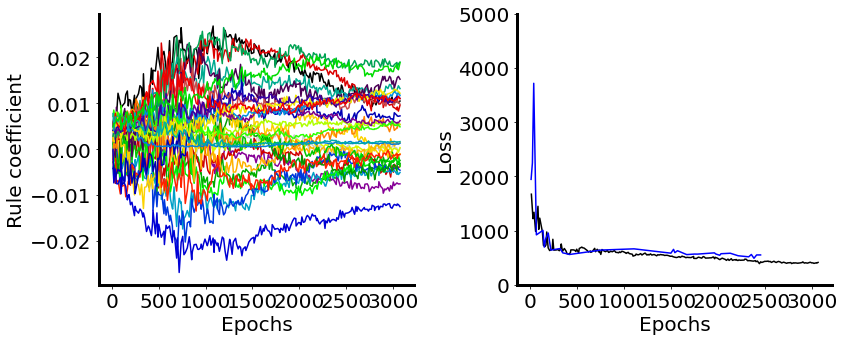

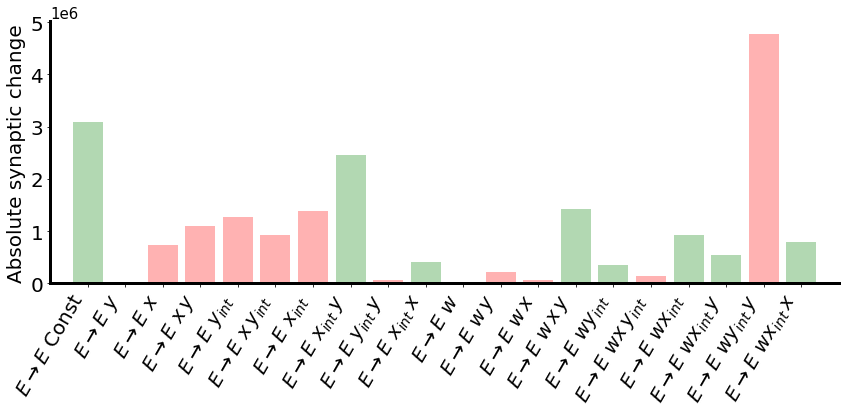

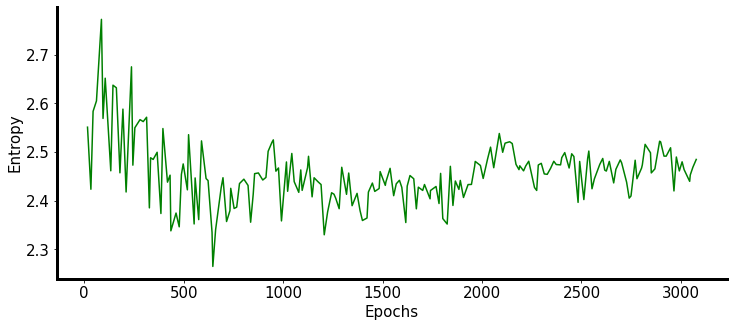

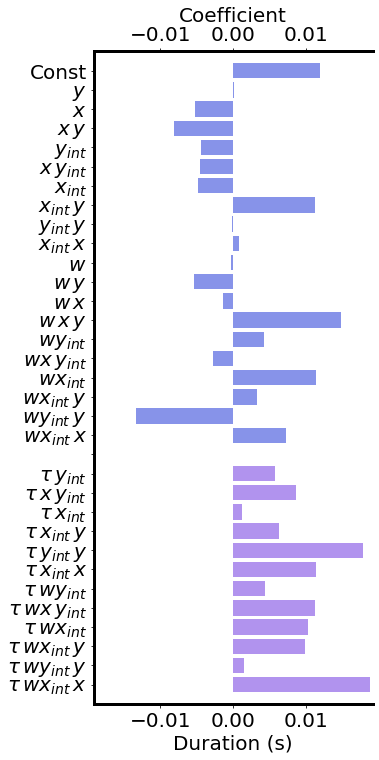

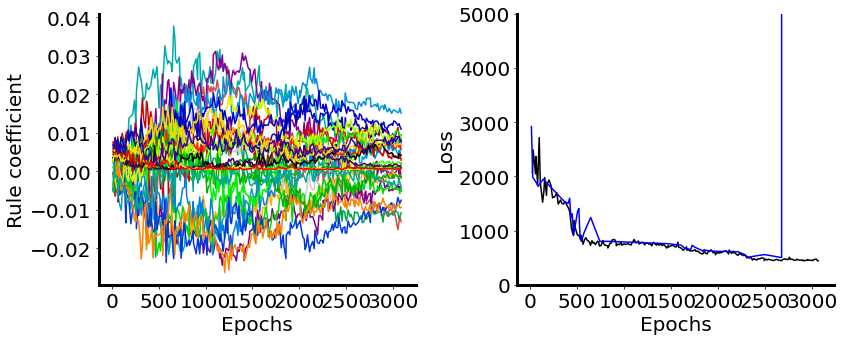

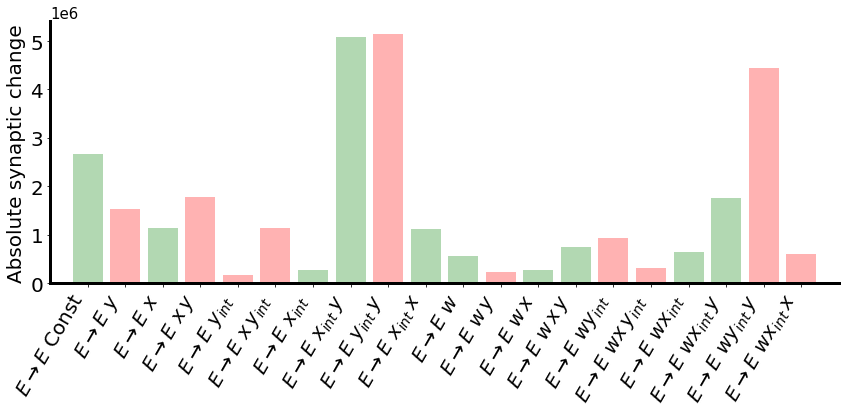

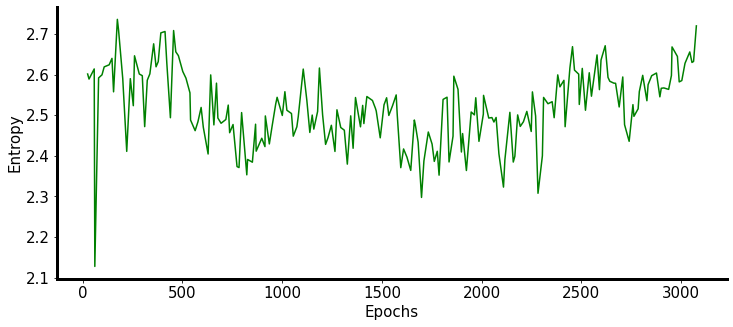

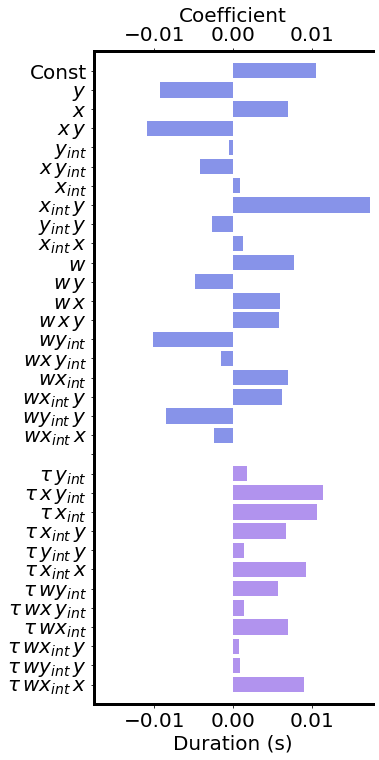

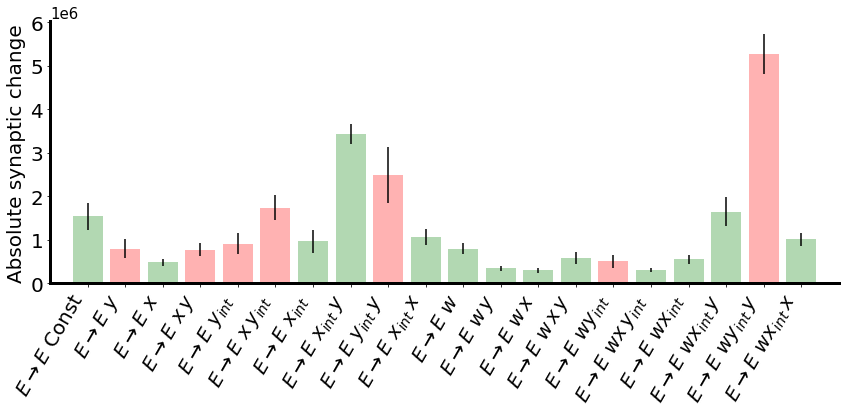

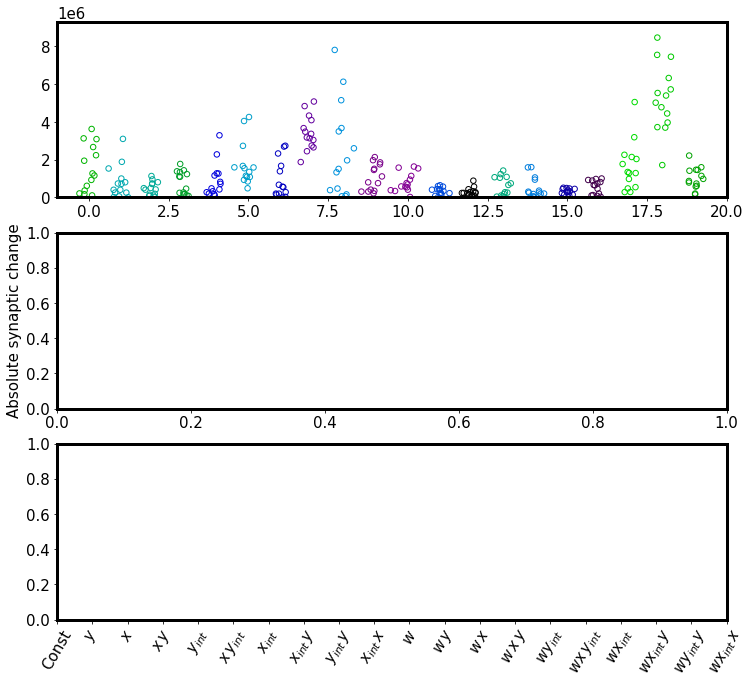

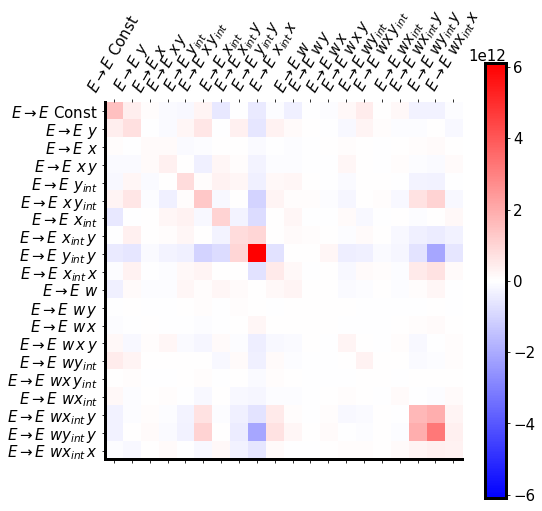

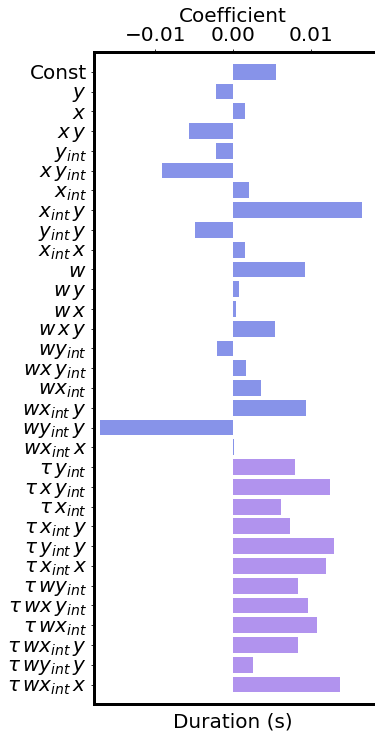

In [5]:
all_files = [
    'decoder_ee_rollback_rescaled_b_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_8000_2023-08-29_23:47:23.365282',
    'decoder_ee_rollback_rescaled_b_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_8001_2023-08-29_23:48:26.168644',
    'decoder_ee_rollback_rescaled_b_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_8002_2023-08-29_23:48:44.153583',
    'decoder_ee_rollback_rescaled_b_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_8003_2023-08-29_23:49:09.077896',
    'decoder_ee_rollback_rescaled_b_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_8004_2023-09-04_07:15:54.654105',
    'decoder_ee_rollback_rescaled_b_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_8005_2023-12-05_17:47:42.563397',
    'decoder_ee_rollback_rescaled_b_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_8006_2023-12-05_19:55:27.149535',
    'decoder_ee_rollback_rescaled_b_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_8007_2023-12-05_19:55:27.014616',
    'decoder_ee_rollback_rescaled_b_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_8008_2023-12-05_21:35:10.287315',
    'decoder_ee_rollback_rescaled_b_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_8009_2023-12-05_21:35:09.973814',
    'decoder_ee_rollback_rescaled_b_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_8010_2023-12-05_21:35:10.274776',
    'decoder_ee_rollback_rescaled_b_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_8011_2023-12-05_21:35:17.791355',
    'decoder_ee_rollback_rescaled_b_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_8012_2023-12-06_04:22:29.292289',
    'decoder_ee_rollback_rescaled_b_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_8013_2023-12-06_04:47:17.666729',
    'decoder_ee_rollback_rescaled_b_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_8014_2023-12-06_04:47:17.612728',
]

plot_all_opt_runs(all_files, 20, 12, 10, l_thresh=500, n_categories=1, name='ee_unperturbed')

decoder_ee_rollback_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_8000_2023-08-24_15:13:49.370832
decoder_ee_rollback_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_8001_2023-08-24_15:13:49.670557
decoder_ee_rollback_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_8002_2023-08-24_15:13:49.676998
[ 0.00415677  0.00084477  0.00462194  0.00157856 -0.01303252 -0.01090289
  0.0120395   0.01978171 -0.00568163 -0.00132477  0.01017513 -0.00391262
 -0.00944978 -0.0045625  -0.00178696 -0.00068552  0.01631595  0.00900707
 -0.01239816 -0.00136674  0.00405026  0.01849191  0.00325607  0.00957823
  0.00627163  0.00450759  0.00792787  0.02200626  0.00707409  0.00216835
  0.00265445  0.00946563]


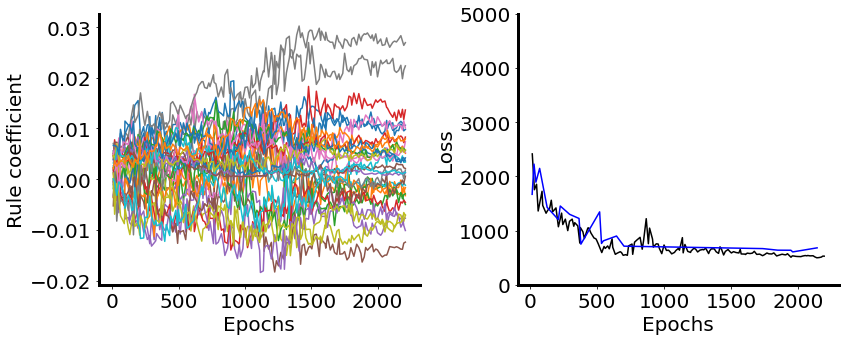

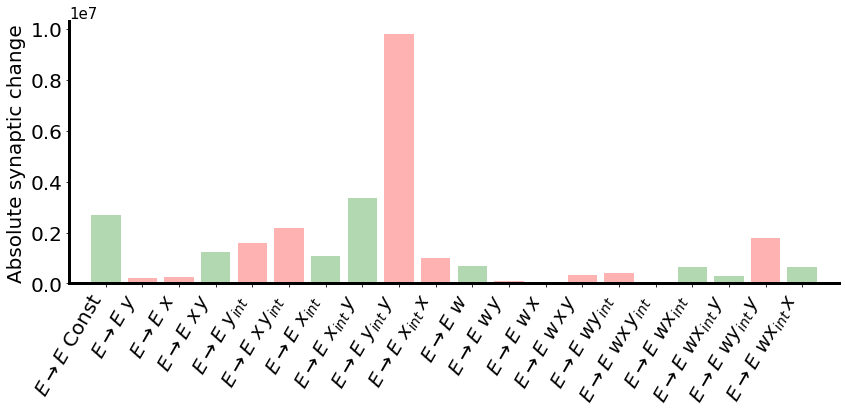

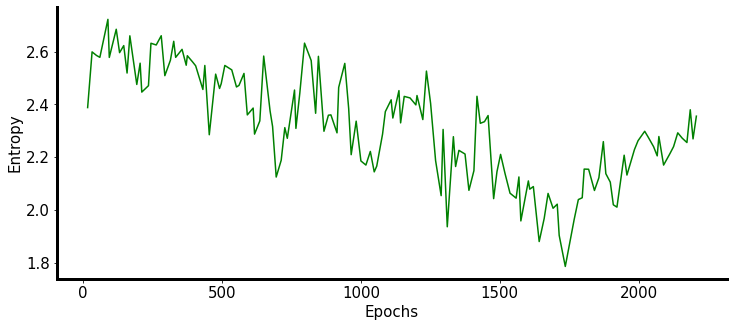

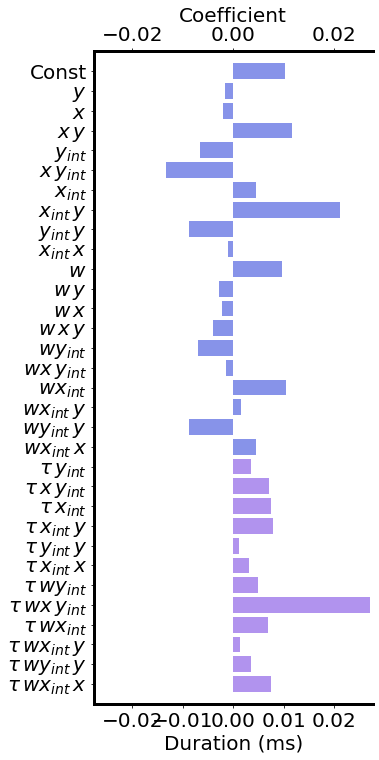

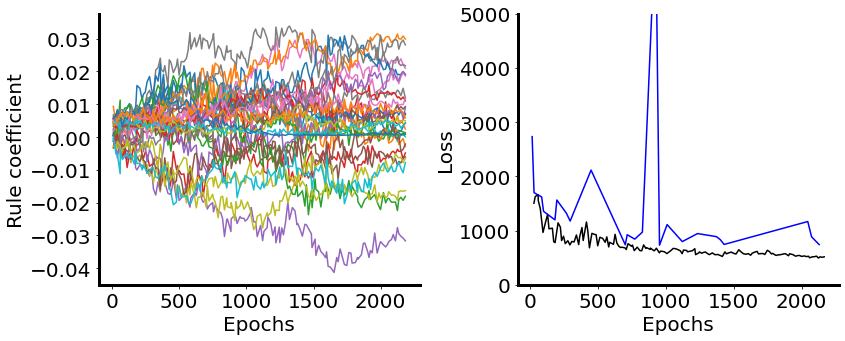

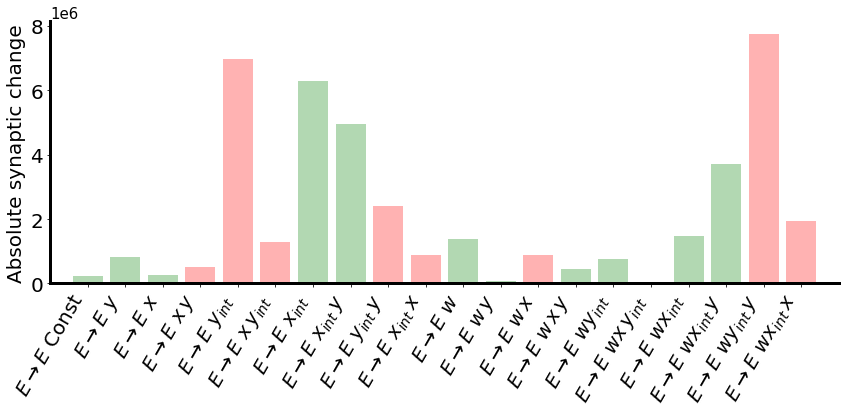

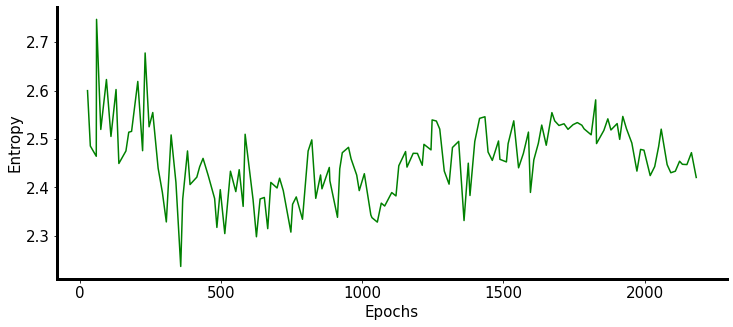

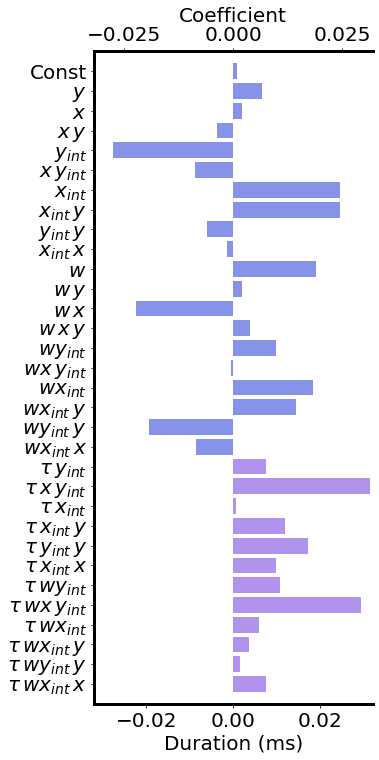

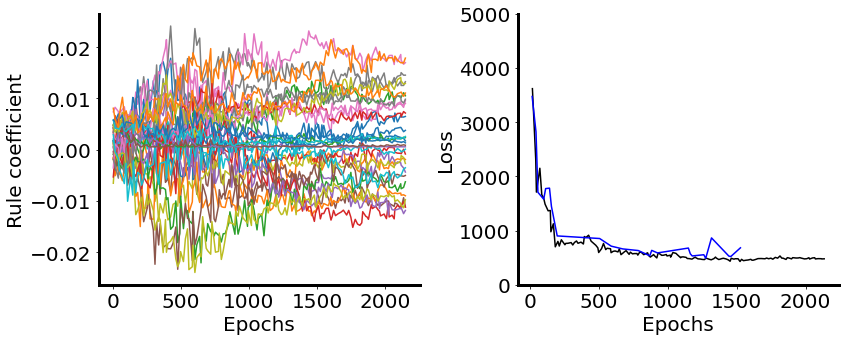

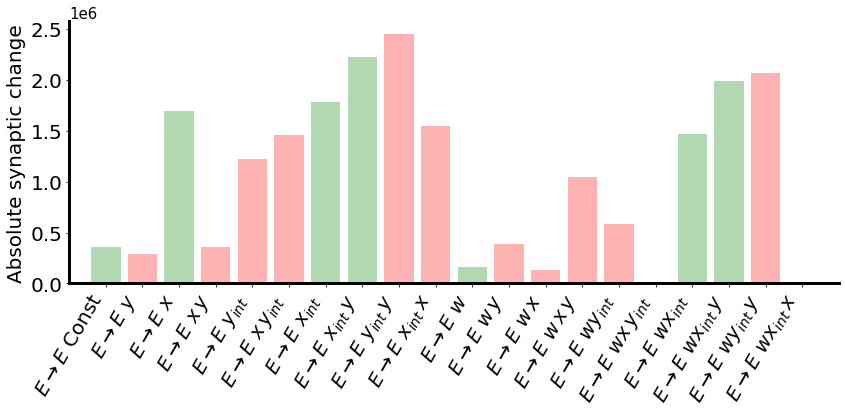

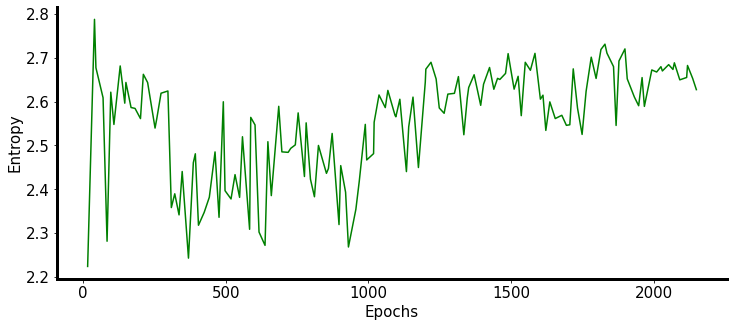

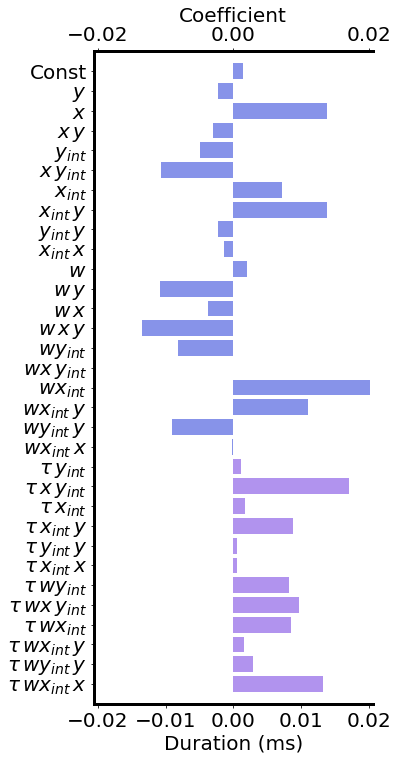

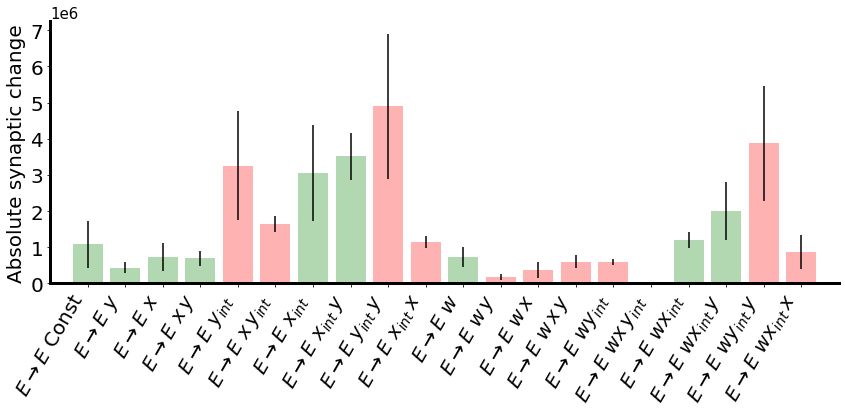

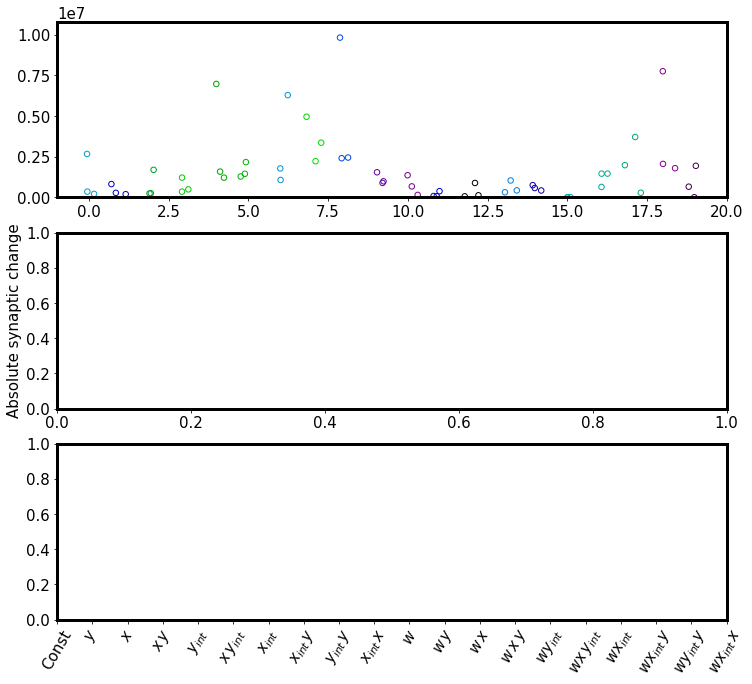

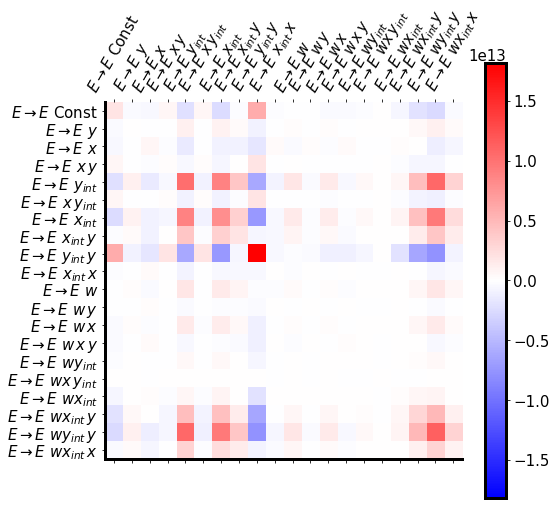

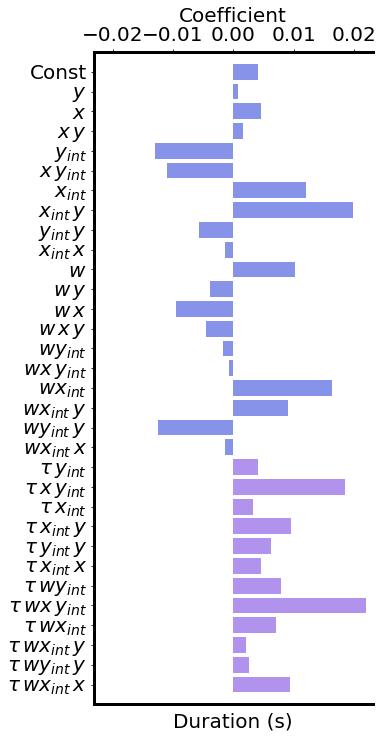

In [5]:
all_files = [
    'decoder_ee_rollback_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_8000_2023-08-24_15:13:49.370832',
    'decoder_ee_rollback_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_8001_2023-08-24_15:13:49.670557',
    'decoder_ee_rollback_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_8002_2023-08-24_15:13:49.676998',
]

plot_all_opt_runs(all_files, 20, 12, 10, l_thresh=500, n_categories=1, name='ee_unperturbed')

# Evaluating learned rules against a test set and dropping out terms to determine importantance

In [28]:
def load_best_avg_params(file_name, n_plasticity_coefs, n_time_constants, batch_size, runs, n_categories=1):
    figure_path = f'./figures/{file_name}'
    Path(figure_path).mkdir(parents=True, exist_ok=True)
    
    scale = 2
    gs = gridspec.GridSpec(5 * n_categories, 1)
    fig = plt.figure(figsize=(6 * scale, 3 * n_categories * scale), tight_layout=True)
    axs = []
    for i in range(n_categories):
        axs.append([fig.add_subplot(gs[i * 3: i * 3 + 2]), fig.add_subplot(gs[i * 3 + 2:i * 3 + 5])])
        
    gs_2 = gridspec.GridSpec(5 * n_categories, 1)
    fig_2 = plt.figure(figsize=(6 * scale, 3 * n_categories * scale), tight_layout=True)
    axs_2 = []
    for i in range(n_categories):
        axs_2.append([fig_2.add_subplot(gs_2[i * 3: i * 3 + 2]), fig_2.add_subplot(gs_2[i * 3 + 2:i * 3 + 5])])
        
    cutoff = 200
    
    for ax in [axs, axs_2]:
        ax[0][1].set_ylabel('Loss')
        ax[0][0].set_xticks([])
        ax[0][1].set_xticks(np.arange(n_plasticity_coefs + 1))
        ax[0][0].set_xticklabels([])
        ax[0][1].set_xticklabels(np.concatenate([['None'], general_rule_names[:n_plasticity_coefs]]), rotation=60, ha='right')
        
        ax[0][0].set_yscale('log')
        ax[0][0].set_ylim(cutoff * 0.5, 1e9)
        ax[0][1].set_ylim(0, cutoff * 1.1)
        ax[0][0].set_xlim(-1, n_plasticity_coefs + 1)
        ax[0][1].set_xlim(-1, n_plasticity_coefs + 1)
        
        ax[0][0].spines['bottom'].set_visible(False)
        ax[0][0].spines['right'].set_visible(False)
        ax[0][1].spines['top'].set_visible(False)
        ax[0][1].spines['right'].set_visible(False)
        
    
    train_data_path = f'./sims_out/{file_name}/train_data.csv'
    df_train = read_csv(train_data_path, read_header=False)

    syn_effect_start = 2 + batch_size + n_plasticity_coefs + n_time_constants
    syn_effect_end = 2 + batch_size + n_plasticity_coefs + n_time_constants + n_plasticity_coefs
    plasticity_coefs_start = 2 + batch_size
    plasticity_coefs_end = 2 + batch_size + n_plasticity_coefs + n_time_constants

    losses = df_train[df_train.columns[1]]
    
    all_losses_for_dropouts = np.array([losses[i:i + runs] for i in range(0, (n_plasticity_coefs + 1) * runs, runs)])
    mean_losses_for_dropouts = np.array([np.mean(ls) for ls in all_losses_for_dropouts])
    std_losses_for_dropouts = np.array([np.std(ls) for ls in all_losses_for_dropouts])
    cis_for_dropouts = 1.96 * (std_losses_for_dropouts / np.sqrt(runs))
    
    sig_diff = np.where(mean_losses_for_dropouts - cis_for_dropouts > mean_losses_for_dropouts[0] + cis_for_dropouts[0], True, False)
    
    means_under_cutoff = mean_losses_for_dropouts < cutoff

    for i in range(0, (n_plasticity_coefs + 1) * runs, runs):
        idx = int(i/runs)
        losses_for_dropout = losses[i:i + runs]
        
        color = 'red' if sig_diff[idx] else 'black'
        
        
        under_cutoff = losses_for_dropout < cutoff
        axs[0][0].scatter((np.ones(runs) * idx + np.random.normal(size=runs, scale=0.15))[~under_cutoff],
                    losses_for_dropout[~under_cutoff], marker='o', facecolor='none', edgecolor=color)
        axs[0][1].scatter((np.ones(runs) * idx + np.random.normal(size=runs, scale=0.15))[under_cutoff],
                    losses_for_dropout[under_cutoff], marker='o', facecolor='none', edgecolor=color)
    
    
        if not means_under_cutoff[idx]:
            axs_2[0][0].errorbar([idx],
                        mean_losses_for_dropouts[idx],
                        yerr=cis_for_dropouts[idx], color=color, capsize=4, linestyle='')
            axs_2[0][0].scatter([idx],
                        mean_losses_for_dropouts[idx], color=color)
        else:
            axs_2[0][1].errorbar([idx], 
                        mean_losses_for_dropouts[idx],
                        yerr=cis_for_dropouts[idx], color=color, capsize=4, linestyle='')
            axs_2[0][1].scatter([idx],
                        mean_losses_for_dropouts[idx], color=color)
    
    set_font_size(axs[0][0], 20)
    set_font_size(axs[0][1], 20)
    fig.savefig(os.path.join(figure_path, 'rule_perturbation.png'))
    fig.savefig(os.path.join(figure_path, 'rule_perturbation.svg'))
        

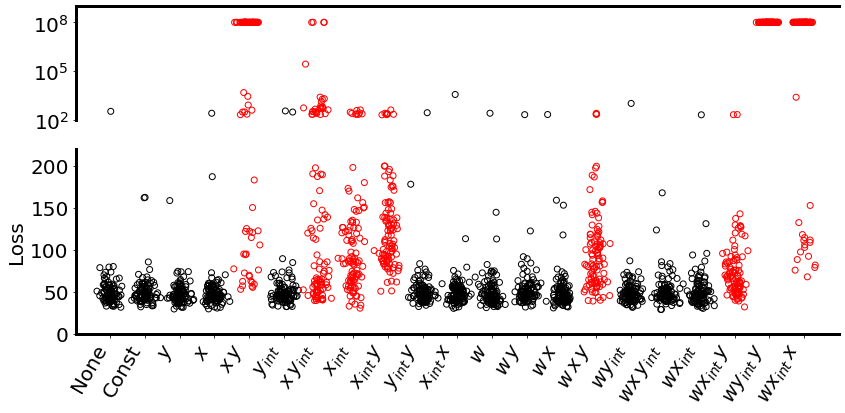

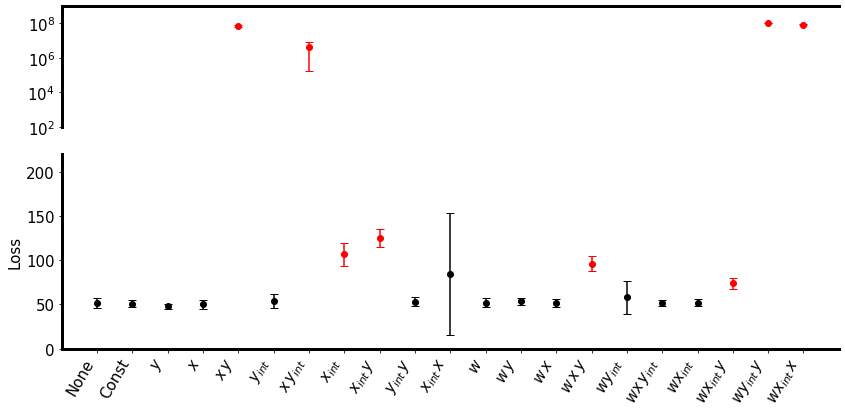

In [29]:
file_name = 'decoder_ee_rollback_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_500_2023-08-31_10:15:00.155072'
load_best_avg_params(file_name, 20, 12, 1, 100, n_categories=1)

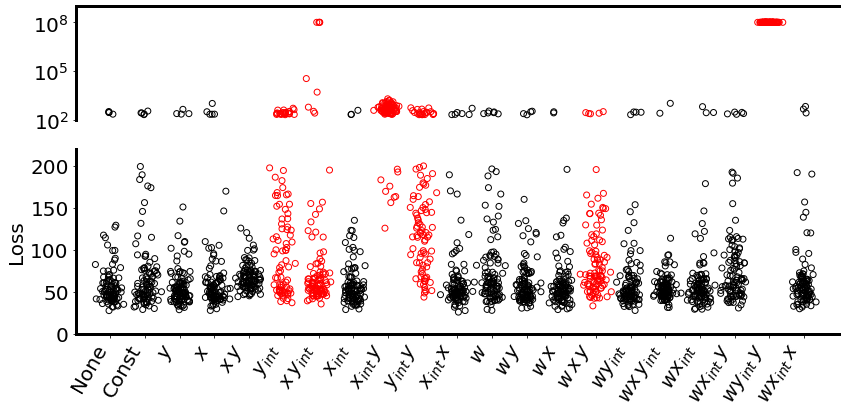

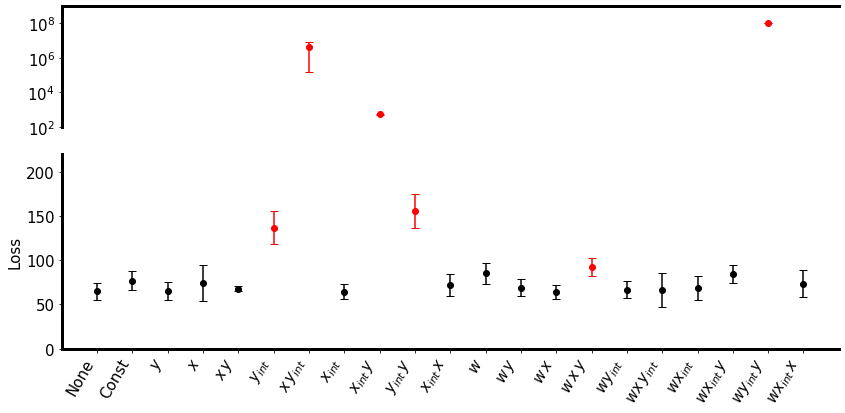

In [30]:
file_name = 'decoder_ee_rollback_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_500_2023-08-31_10:17:00.379851'
load_best_avg_params(file_name, 20, 12, 1, 100, n_categories=1)

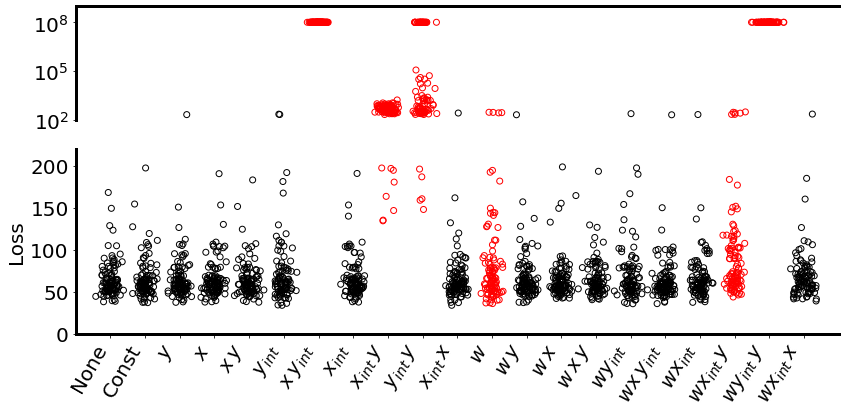

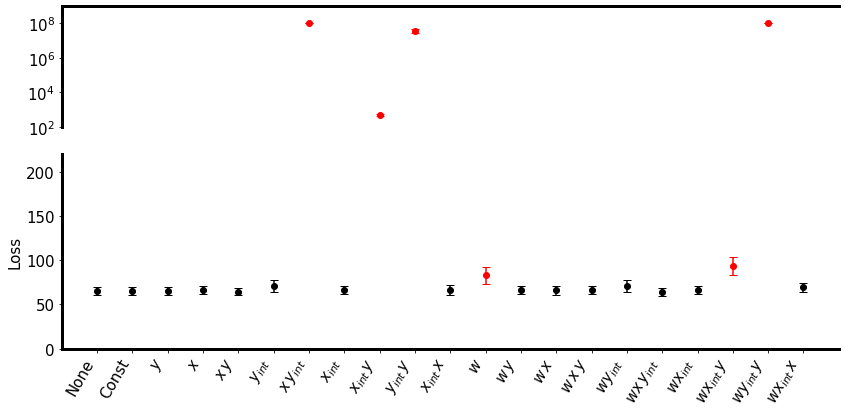

In [31]:
file_name = 'decoder_ee_rollback_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_500_2023-08-31_10:17:01.105619'
load_best_avg_params(file_name, 20, 12, 1, 100, n_categories=1)

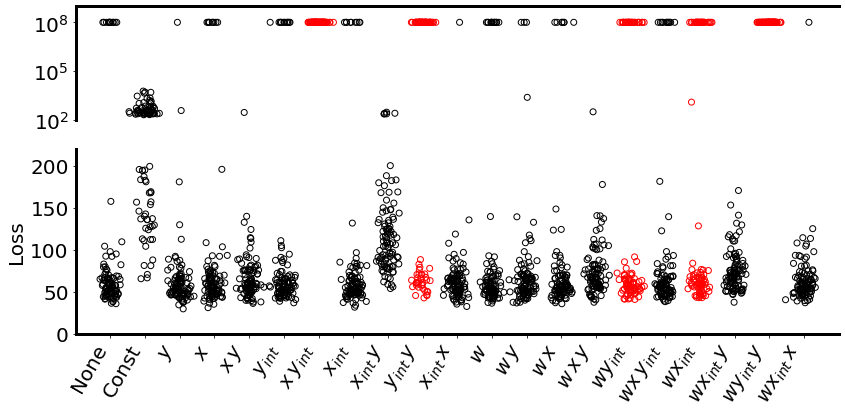

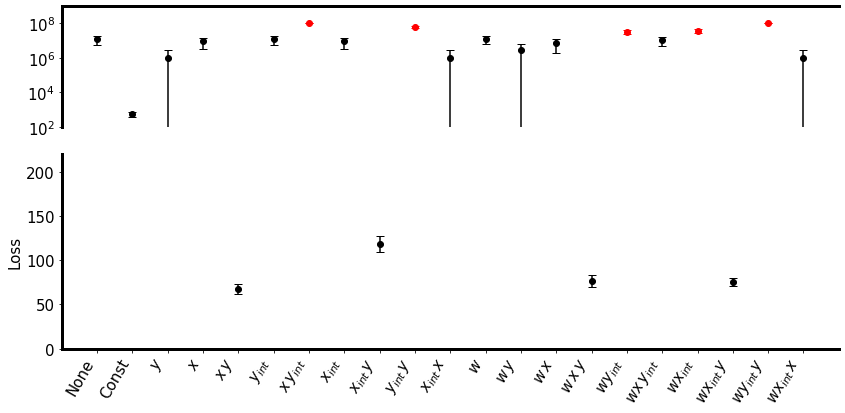

In [32]:
file_name = 'decoder_ee_rollback_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_500_2023-08-31_12:07:49.829874'
load_best_avg_params(file_name, 20, 12, 1, 100, n_categories=1)

# Ordering terms by KL divergence between dropped term case and null case

Here, we use the KL divergence between the dropout test cases and the no-dropout case to determine a heirarchy of term importance. 

In [14]:
def compute_kl_divs(file_name, n_plasticity_coefs, n_time_constants, batch_size, runs, n_categories=1):
    figure_path = f'./figures/{file_name}'
    Path(figure_path).mkdir(parents=True, exist_ok=True)        
    
    train_data_path = f'./sims_out/{file_name}/train_data.csv'
    df_train = read_csv(train_data_path, read_header=False)

    syn_effect_start = 2 + batch_size + n_plasticity_coefs + n_time_constants
    syn_effect_end = 2 + batch_size + n_plasticity_coefs + n_time_constants + n_plasticity_coefs
    plasticity_coefs_start = 2 + batch_size
    plasticity_coefs_end = 2 + batch_size + n_plasticity_coefs + n_time_constants

    losses = df_train[df_train.columns[1]]
    
    all_losses_for_dropouts = np.array([losses[i:i + runs] for i in range(0, (n_plasticity_coefs + 1) * runs, runs)])
    
    max_loss, min_loss = all_losses_for_dropouts.max(), all_losses_for_dropouts.min()
    bins = np.power(1.2, np.arange(100))
    bins = (max_loss - min_loss) * (bins - bins.min()) / bins.max() + min_loss
    
    null_dist, _ = np.histogram(all_losses_for_dropouts[0, :], bins=bins, density=True)
    
    kl_divs = []
    
#     print(null_dist)

    epsilon = 1e-10
    
    for d_idx in np.arange(1, all_losses_for_dropouts.shape[0]):
        term_dropped_dist, _ = np.histogram(all_losses_for_dropouts[d_idx, :], bins=bins, density=True)
        
        prob_ratio = null_dist / term_dropped_dist
        
#         print(d_idx)
#         print(term_dropped_dist)
#         print(np.sum(term_dropped_dist))
        
        kl_divergence = np.sum((null_dist + epsilon) * np.log((null_dist + epsilon) / (term_dropped_dist + epsilon)))
        
        kl_divs.append(kl_divergence)
        
    return np.array(kl_divs)
        

In [9]:
file_name = 'decoder_ee_rollback_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_500_2023-08-31_10:15:00.155072'
kl_divs = compute_kl_divs(file_name, 20, 12, 1, 100, n_categories=1)
write_path = f'./sims_out/{file_name}/rule_ranking.csv'

write_csv(write_path, [
    [],
    np.argsort(-kl_divs),
    kl_divs[np.argsort(-kl_divs)],
    [general_rule_names[i] for i in np.argsort(-kl_divs)]
])

In [11]:
file_name = 'decoder_ee_rollback_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_500_2023-08-31_10:17:00.379851'
kl_divs = compute_kl_divs(file_name, 20, 12, 1, 100, n_categories=1)
write_path = f'./sims_out/{file_name}/rule_ranking.csv'

write_csv(write_path, [
    [],
    np.argsort(-kl_divs),
    kl_divs[np.argsort(-kl_divs)],
    [general_rule_names[i] for i in np.argsort(-kl_divs)]
])

In [12]:
file_name = 'decoder_ee_rollback_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_500_2023-08-31_10:17:01.105619'
kl_divs = compute_kl_divs(file_name, 20, 12, 1, 100, n_categories=1)
write_path = f'./sims_out/{file_name}/rule_ranking.csv'

write_csv(write_path, [
    [],
    np.argsort(-kl_divs),
    kl_divs[np.argsort(-kl_divs)],
    [general_rule_names[i] for i in np.argsort(-kl_divs)]
])

In [13]:
file_name = 'decoder_ee_rollback_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_500_2023-08-31_12:07:49.829874'
kl_divs = compute_kl_divs(file_name, 20, 12, 1, 100, n_categories=1)
write_path = f'./sims_out/{file_name}/rule_ranking.csv'

write_csv(write_path, [
    [],
    np.argsort(-kl_divs),
    kl_divs[np.argsort(-kl_divs)],
    [general_rule_names[i] for i in np.argsort(-kl_divs)]
])

# Building the model progressively to determine terms of true importance

Loss vs loss of full model

In [11]:
def fetch_minimum_loss(file_name, n_plasticity_coefs, n_time_constants, batch_size, n_categories=1):
    figure_path = f'./figures/{file_name}'
    Path(figure_path).mkdir(parents=True, exist_ok=True)        
    
    train_data_path = f'./sims_out/{file_name}/train_data.csv'
    test_data_path = f'./sims_out/{file_name}/test_data.csv'
    df_train = read_csv(train_data_path, read_header=False)
    df_test = read_csv(test_data_path, read_header=False)

    syn_effect_start = 2 + batch_size + n_plasticity_coefs + n_time_constants
    syn_effect_end = 2 + batch_size + n_plasticity_coefs + n_time_constants + n_plasticity_coefs
    plasticity_coefs_start = 2 + batch_size
    plasticity_coefs_end = 2 + batch_size + n_plasticity_coefs + n_time_constants

    losses = df_train[df_train.columns[1]]
    min_loss_idx = df_train[df_train.columns[0]][np.argmin(losses)]
    print(min_loss_idx)
    
    losses_test = df_test[df_test.columns[1]]
    
    return np.min(losses), np.min(losses_test)

906.0
993.0
751.0
825.0
809.0
639.0
872.0


Text(0.5, 0, 'No. terms included')

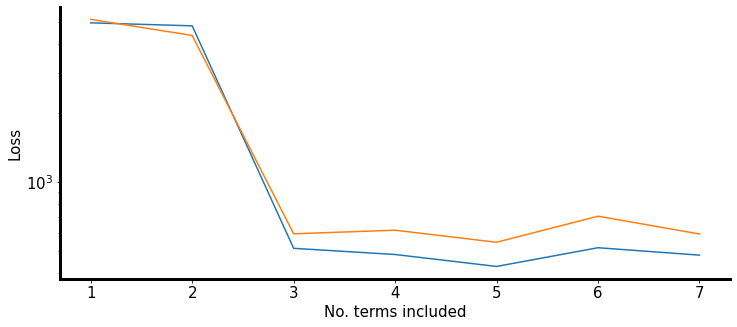

In [13]:
file_names = [
    'refit_ee_ss_1_terms_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_501_2023-09-06_22:32:29.011316',
    'refit_ee_ss_2_terms_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_501_2023-09-06_22:33:28.698593',
    'refit_ee_ss_3_terms_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_501_2023-09-06_22:33:42.266508',
    'refit_ee_ss_4_terms_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_501_2023-09-06_22:34:54.550166',
    'refit_ee_ss_5_terms_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_501_2023-09-06_22:35:09.426952',
    'refit_ee_ss_6_terms_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_501_2023-09-06_22:37:03.370791',
    'refit_ee_ss_7_terms_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_501_2023-09-06_22:37:02.547151',
]

all_losses = []
all_losses_test = []
for f in file_names:
    min_loss, min_loss_test = fetch_minimum_loss(f, 20, 12, 10)
    all_losses.append(min_loss)
    all_losses_test.append(min_loss_test)

scale = 2
fig, axs = plt.subplots(1, 1, figsize=(6 * scale, 2.5 * scale))
format_axs(axs)

axs.plot(np.arange(1, 8), all_losses)
axs.plot(np.arange(1, 8), all_losses_test)
axs.set_yscale('log')
# axs.set_ylim(0, 3000)
axs.set_ylabel('Loss')
axs.set_xlabel('No. terms included')

In [12]:
def plot_elbo_curve(file_name, n_plasticity_coefs, n_time_constants, batch_size, runs, n_categories=1, full_rules_file_name=None):
    figure_path = f'./figures/{file_name}'
    Path(figure_path).mkdir(parents=True, exist_ok=True)
    
    train_data_path = f'./sims_out/{file_name}/train_data.csv'
    df_train = read_csv(train_data_path, read_header=False)

    syn_effect_start = 2 + batch_size + n_plasticity_coefs + n_time_constants
    syn_effect_end = 2 + batch_size + n_plasticity_coefs + n_time_constants + n_plasticity_coefs
    plasticity_coefs_start = 2 + batch_size
    plasticity_coefs_end = 2 + batch_size + n_plasticity_coefs + n_time_constants

    losses = df_train[df_train.columns[1]]
    
    all_losses_for_terms = np.array([losses[i:i + runs] for i in range(0,  len(losses), runs)])
    mean_losses_for_terms = np.array([np.mean(ls) for ls in all_losses_for_terms])
    std_losses_for_terms = np.array([np.std(ls) for ls in all_losses_for_terms])
    cis_for_terms = 1.96 * (std_losses_for_terms / np.sqrt(runs))
    
    cutoff = 200
    
    scale = 2
    gs = gridspec.GridSpec(5 * n_categories, 1)
    fig = plt.figure(figsize=(6 * scale, 3 * n_categories * scale), tight_layout=True)
    axs = [fig.add_subplot(gs[:2]), fig.add_subplot(gs[2:5])]
    
    axs[1].set_ylabel('Loss')
    axs[0].set_xticks([])
    axs[0].set_xlim(0.5, 8.5)
    axs[0].set_xticklabels([])
    axs[1].set_xticklabels(np.concatenate([np.arange(0, 8), ['All']]))
    axs[1].set_xlabel('No. terms included')
    axs[1].set_xlim(0.5, 8.5)

    axs[0].set_yscale('log')
    axs[0].set_ylim(cutoff * 0.5, 1e9)
    axs[1].set_ylim(0, cutoff * 1.1)

    axs[0].spines['bottom'].set_visible(False)
    axs[0].spines['right'].set_visible(False)
    axs[1].spines['top'].set_visible(False)
    axs[1].spines['right'].set_visible(False)
    
    for term_idx in np.arange(all_losses_for_terms.shape[0]):
        
        mask_over_cutoff = all_losses_for_terms[term_idx] > cutoff
        
        axs[0].scatter(
            (runs * [term_idx + 1] + np.random.normal(size=runs, scale=0.15))[mask_over_cutoff],
            all_losses_for_terms[term_idx][mask_over_cutoff],
            marker='o',
            facecolor='none',
            edgecolor='blue',
        )
        
        axs[1].scatter(
            (runs * [term_idx + 1] + np.random.normal(size=runs, scale=0.15))[~mask_over_cutoff],
            all_losses_for_terms[term_idx][~mask_over_cutoff],
            marker='o',
            facecolor='none',
            edgecolor='blue',
        )
    
    if full_rules_file_name is not None:
        train_data_path_fm = f'./sims_out/{full_rules_file_name}/train_data.csv'
        df_train_fm = read_csv(train_data_path_fm, read_header=False)
        
        losses_fm = df_train_fm[df_train_fm.columns[1]][:runs]
        
        mask_over_cutoff = losses_fm > cutoff
        
        axs[0].scatter(
            (runs * [term_idx + 2] + np.random.normal(size=runs, scale=0.15))[mask_over_cutoff],
            losses_fm[mask_over_cutoff],
            marker='o',
            facecolor='none',
            edgecolor='black',
        )
        
        axs[1].scatter(
            (runs * [term_idx + 2] + np.random.normal(size=runs, scale=0.15))[~mask_over_cutoff],
            losses_fm[~mask_over_cutoff],
            marker='o',
            facecolor='none',
            edgecolor='black',
        )
    
    set_font_size(axs[0], 20)
    set_font_size(axs[1], 20)
        
    fig.savefig(os.path.join(figure_path, 'rule_perturbation.png'))
    fig.savefig(os.path.join(figure_path, 'rule_perturbation.svg'))
        

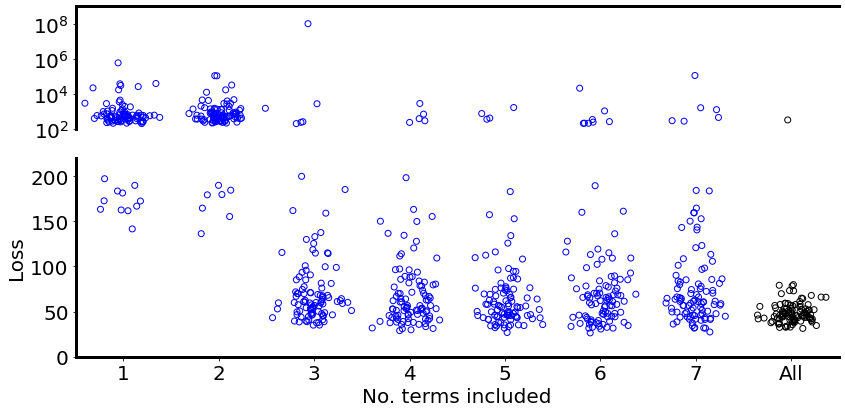

In [13]:
plot_elbo_curve(
    'refit_test_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_600_2023-09-07_23:37:18.691126',
    20,
    12,
    1,
    100,
    n_categories=1,
    full_rules_file_name='decoder_ee_rollback_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_500_2023-08-31_10:15:00.155072',
)

# What happens if synaptic turnover is introduced?

In [45]:
def plot_all_losses(file_names, n_plasticity_coefs, n_time_constants, batch_size, n_categories=1, colors=None, labels=None):
    syn_effect_start = 2 + batch_size + n_plasticity_coefs + n_time_constants
    syn_effect_end = 2 + batch_size + n_plasticity_coefs + n_time_constants + n_plasticity_coefs
    plasticity_coefs_start = 2 + batch_size
    plasticity_coefs_end = 2 + batch_size + n_plasticity_coefs + n_time_constants
    
    cutoff = 1000
    
    scale = 2
    gs = gridspec.GridSpec(5 * n_categories, 1)
    fig = plt.figure(figsize=(6 * scale, 3.5 * n_categories * scale), tight_layout=True)
    axs = [fig.add_subplot(gs[:2]), fig.add_subplot(gs[2:5])]
    
    axs[1].set_ylabel('Loss')
    axs[0].set_xticks([])
    axs[0].set_xlim(0, len(file_names) + 1)
    axs[0].set_xticklabels([])
#     axs[1].set_xticklabels(np.concatenate([np.arange(0, len(file_names)), ['All']]))
#     axs[1].set_xlabel('No. terms included')
    axs[1].set_xlim(0, len(file_names) + 1)

    axs[0].set_yscale('log')
    axs[0].set_ylim(cutoff * 0.5, 1e9)
    axs[1].set_ylim(0, cutoff * 1.1)
    if labels is None:
        labels = [''] + ['Summed\nsynaptic'] * 2 + ['Meta-learned'] * 2 + ['Meta-learned\nwith turnover'] * 2
    axs[1].set_xticklabels(labels, rotation=30)

    axs[0].spines['bottom'].set_visible(False)
    axs[0].spines['right'].set_visible(False)
    axs[1].spines['top'].set_visible(False)
    axs[1].spines['right'].set_visible(False)
    
    if colors is None:
        colors = ['black', 'green', 'black', 'green', 'black', 'green']
    
    for file_idx, file_name in enumerate(file_names): 
        train_data_path = f'./sims_out/{file_name}/train_data.csv'

        df_train = read_csv(train_data_path, read_header=False)
        
        losses = df_train[df_train.columns[1]]
        
        print(np.median(losses))
        
        mask_over_cutoff = losses > cutoff
        
        axs[0].scatter(
            (len(losses) * [file_idx + 1] + np.random.normal(size=len(losses), scale=0.10))[mask_over_cutoff],
            losses[mask_over_cutoff],
            marker='o',
            facecolor='none',
            edgecolor=colors[file_idx],
            
        )
        
        axs[1].scatter(
            (len(losses) * [file_idx + 1] + np.random.normal(size=len(losses), scale=0.10))[~mask_over_cutoff],
            losses[~mask_over_cutoff],
            marker='o',
            facecolor='none',
            edgecolor=colors[file_idx],
            
        )
        
        
    set_font_size(axs[0], 22)
    set_font_size(axs[1], 22)
    fig.savefig('figures/stress_test_comp_ila.png')
    fig.savefig('figures/stress_test_comp_ila.svg')
    
        

FileNotFoundError: [Errno 2] No such file or directory: './sims_out/ila_network_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_700_2023-09-08_14:12:57.175017/train_data.csv'

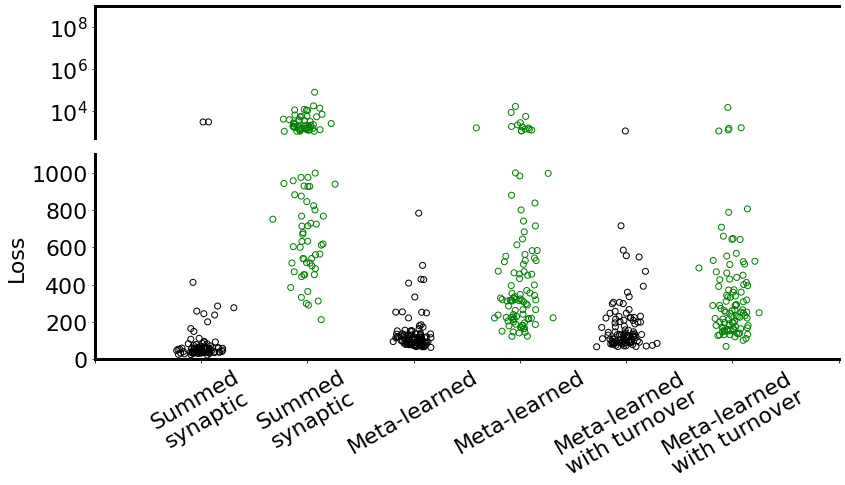

In [46]:
plot_all_losses([
    'ila_network_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_700_2023-09-08_14:12:57.175017',
    'ila_network_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_700_2023-09-08_14:13:35.002314',
    'stress_test_ee_unpert_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_700_2023-09-08_10:53:02.459275',
    'stress_test_ee_unpert_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_700_2023-09-08_10:54:41.632693',
    'stress_test_ee_pert_4_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_700_2023-09-08_12:04:01.566259',
    'stress_test_ee_pert_4_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_700_2023-09-08_12:05:05.484616'
], 20, 12, 1, n_categories=1)

92.26789448097274
105.68200186975604
148.33032153710997
211.0335113479535


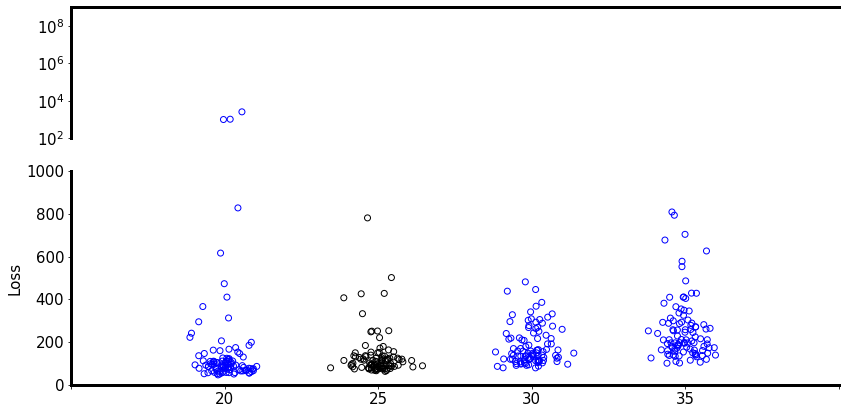

In [49]:
plot_all_losses([
    'stress_test_ee_unpert_20_cell_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_700_2023-09-08_14:22:32.863267',
    'stress_test_ee_unpert_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_700_2023-09-08_10:53:02.459275',
    'stress_test_ee_unpert_30_cell_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_700_2023-09-08_14:24:03.527532',
    'stress_test_ee_unpert_35_cell_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_700_2023-09-08_14:36:38.242252',
], 20, 12, 1, n_categories=1, colors=['blue', 'black', 'blue', 'blue'], labels=['', '20', '25', '30', '35'])

decoder_ee_rollback_rescaled_b_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_8000_2023-09-04_07:13:27.589319
decoder_ee_rollback_rescaled_b_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_8001_2023-09-04_07:13:33.739864
decoder_ee_rollback_rescaled_b_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_8002_2023-09-04_07:13:46.762137
decoder_ee_rollback_rescaled_b_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_8003_2023-09-04_07:13:41.637903
decoder_ee_rollback_rescaled_b_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_8004_2023-09-04_07:15:46.827837
[ 9.56907232e-03 -2.52737973e-03  3.70464424e-03 -1.53763942e-03
  3.17280990e-03 -3.69970995e-03  4.12989359e-03  1.85855782e-02
 -4.45436894e-03  9.62596408e-05  8.55125958e-03 -7.966

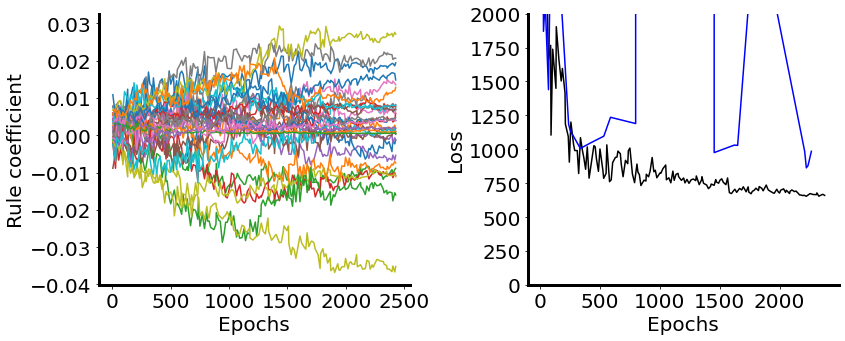

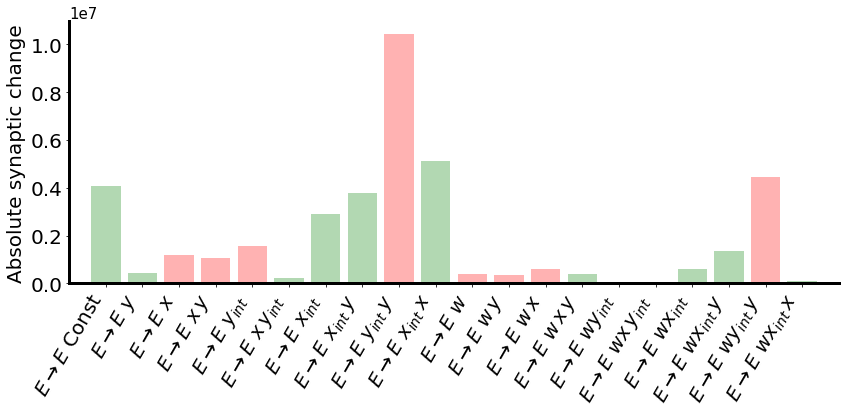

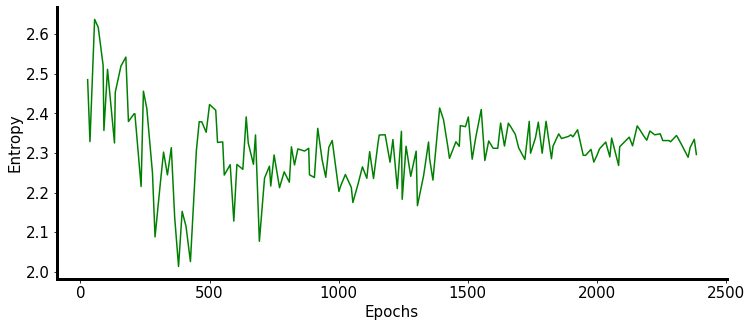

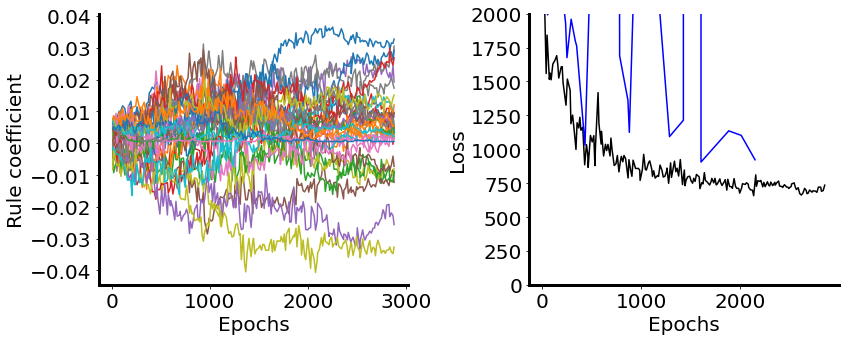

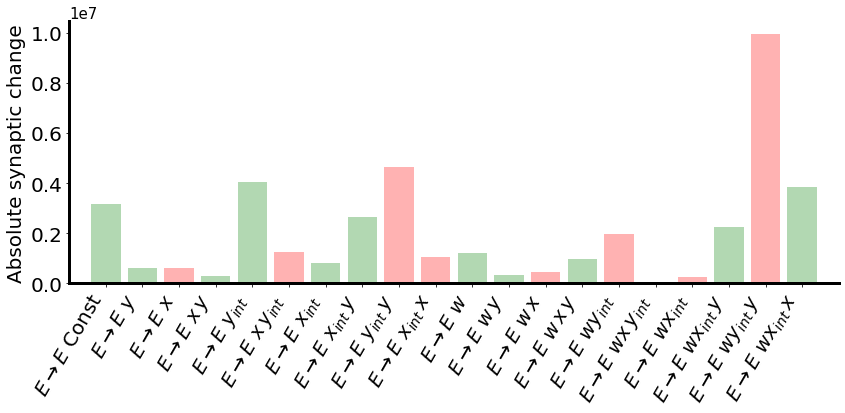

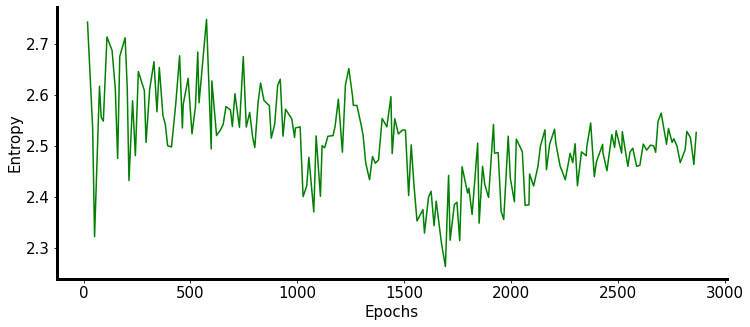

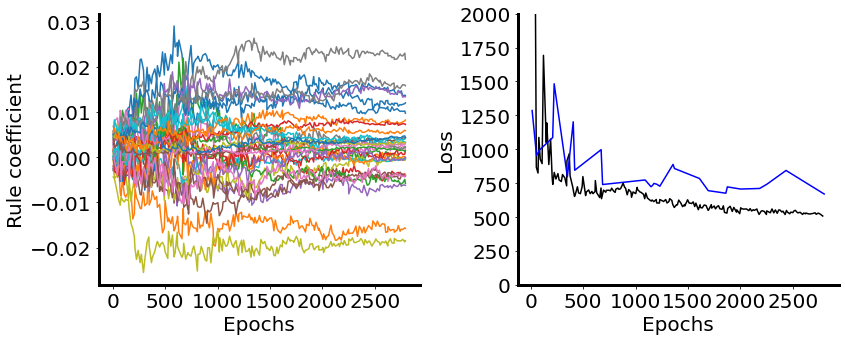

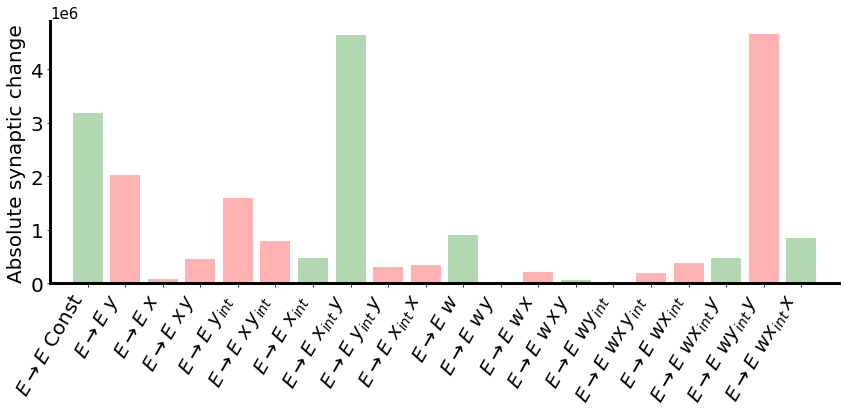

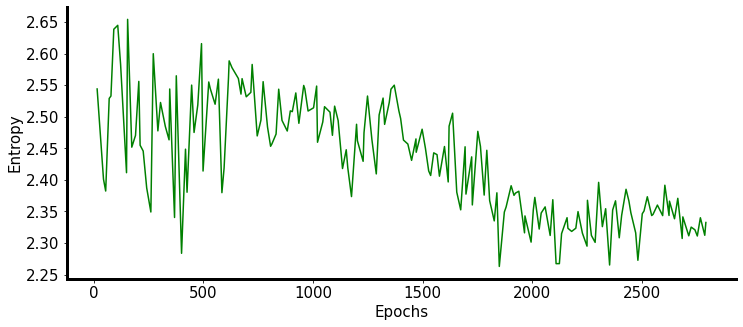

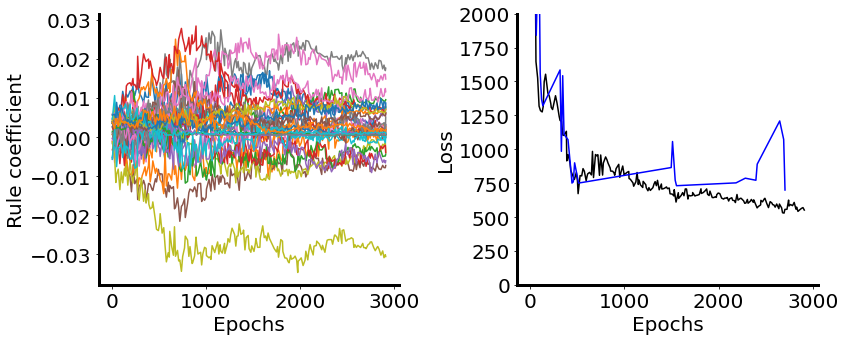

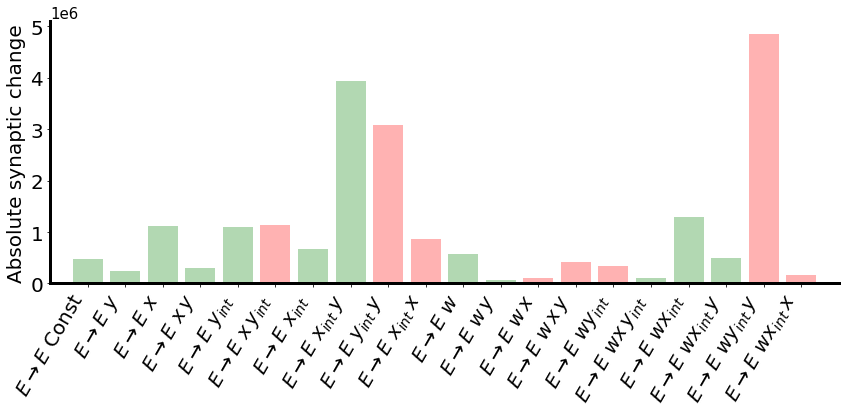

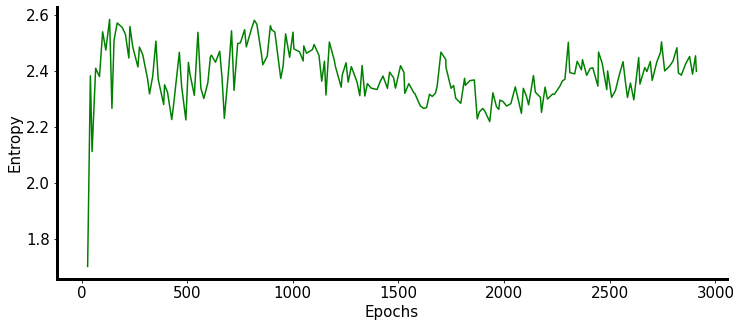

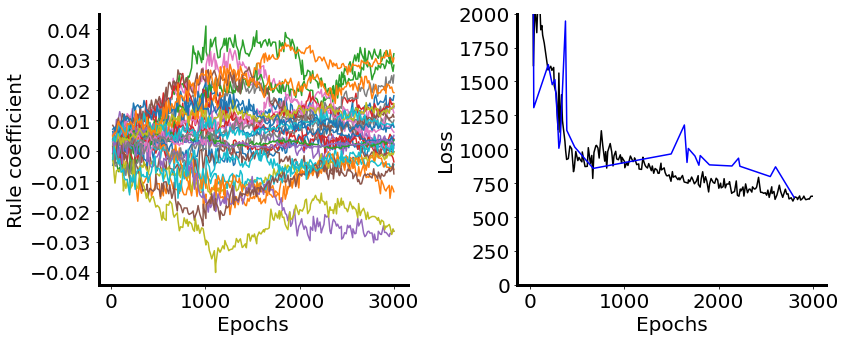

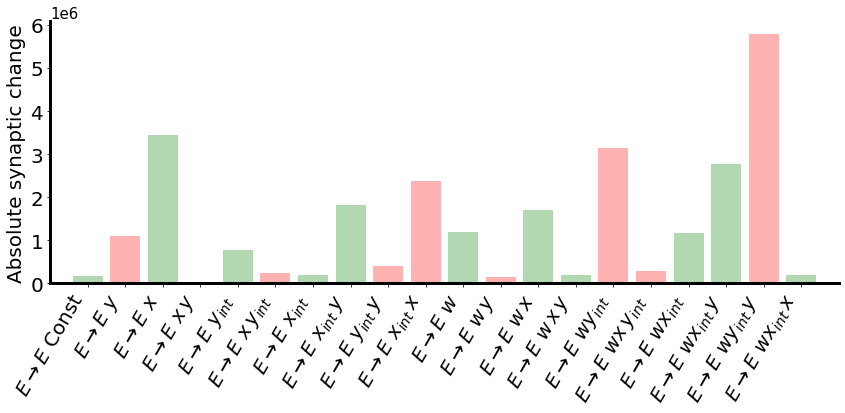

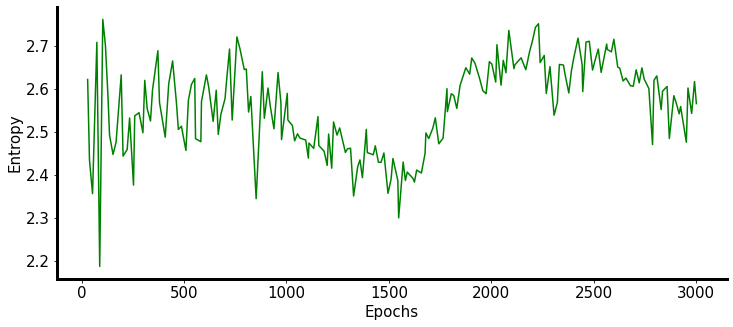

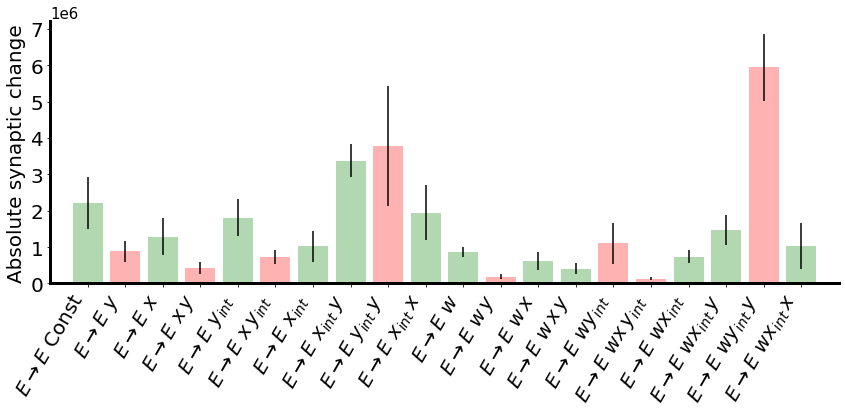

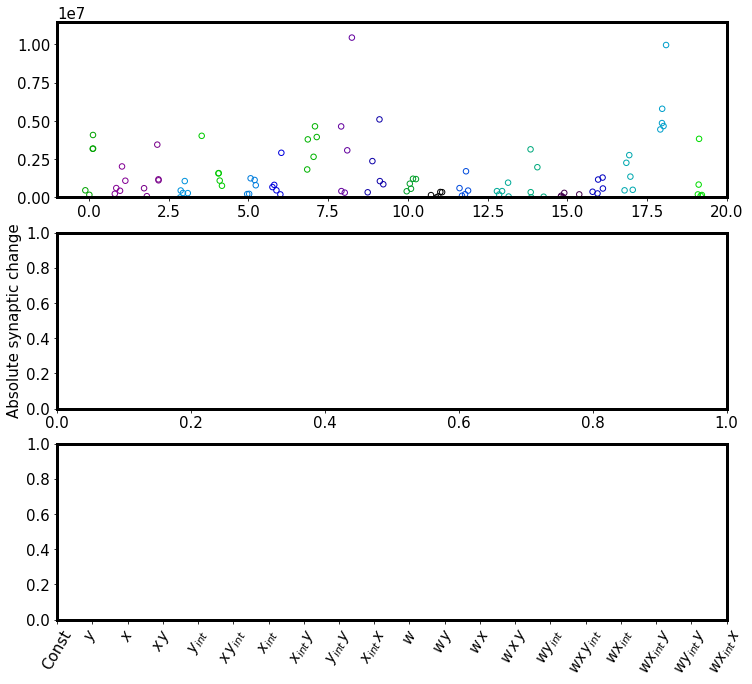

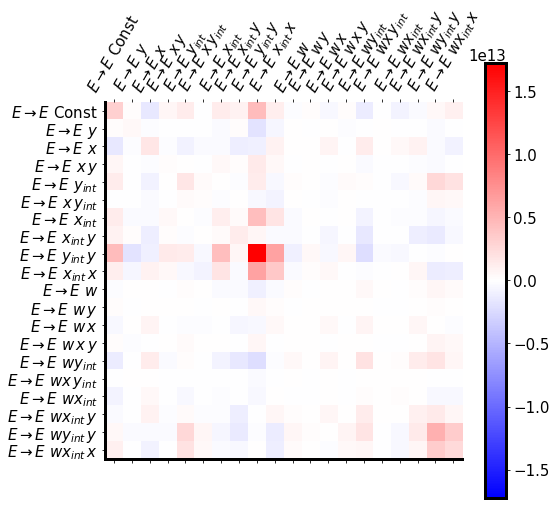

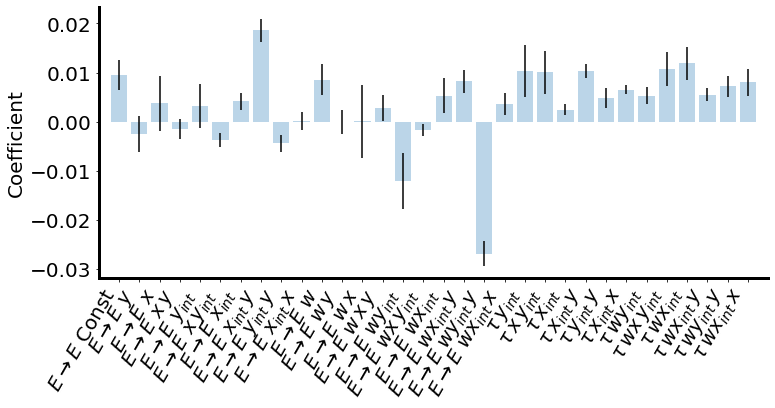

In [5]:
all_files = [
    'decoder_ee_rollback_rescaled_b_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_8000_2023-09-04_07:13:27.589319',
    'decoder_ee_rollback_rescaled_b_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_8001_2023-09-04_07:13:33.739864',
    'decoder_ee_rollback_rescaled_b_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_8002_2023-09-04_07:13:46.762137',
    'decoder_ee_rollback_rescaled_b_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_8003_2023-09-04_07:13:41.637903',
    'decoder_ee_rollback_rescaled_b_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_8004_2023-09-04_07:15:46.827837',
]

plot_all_opt_runs(all_files, 20, 12, 10, l_thresh=800, n_categories=1, name='ee_perturbed')

# Probing solutions for important terms using dropout method (synaptic turnover case)

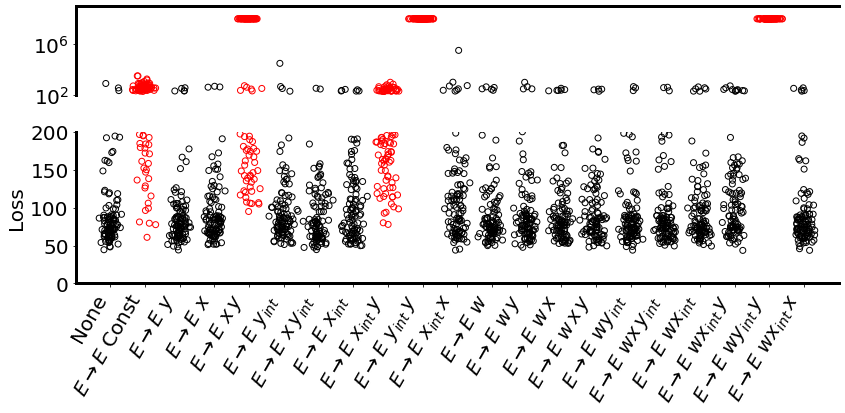

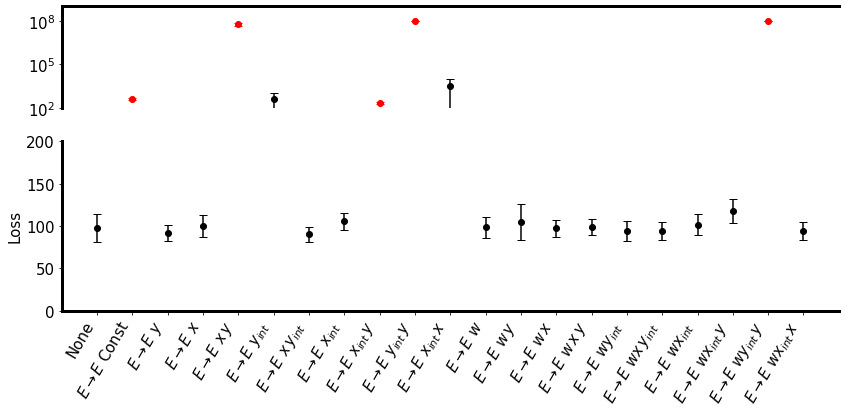

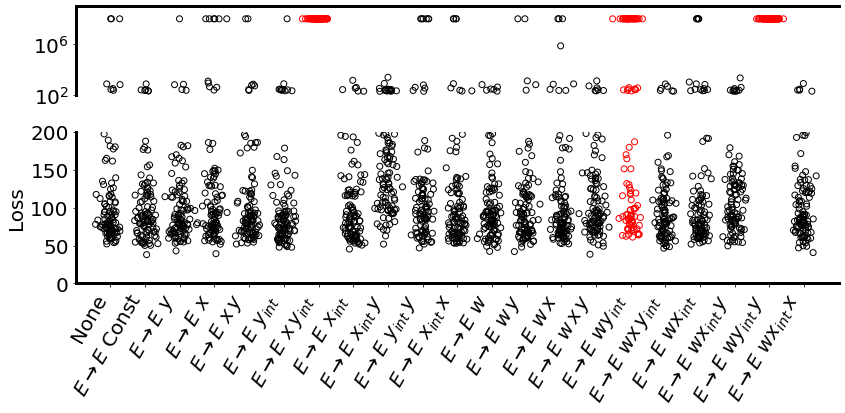

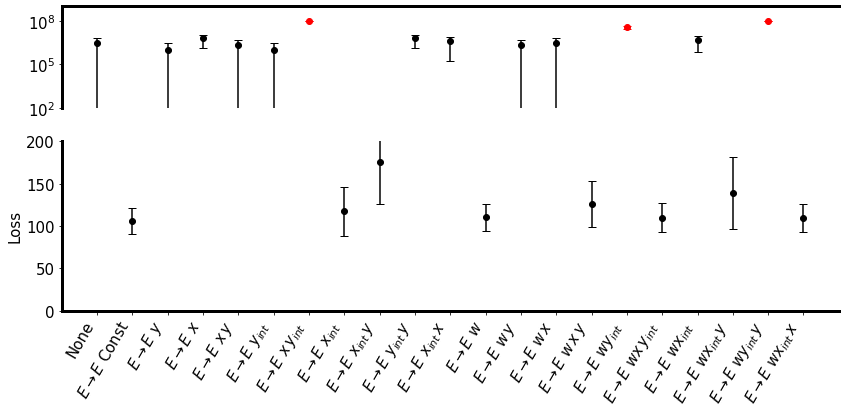

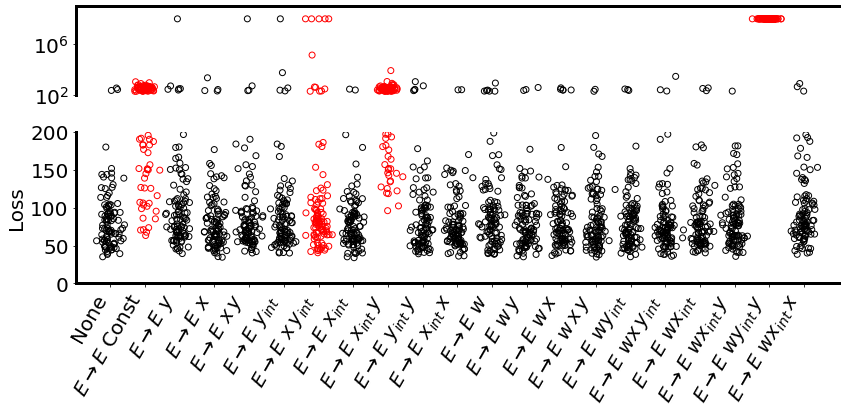

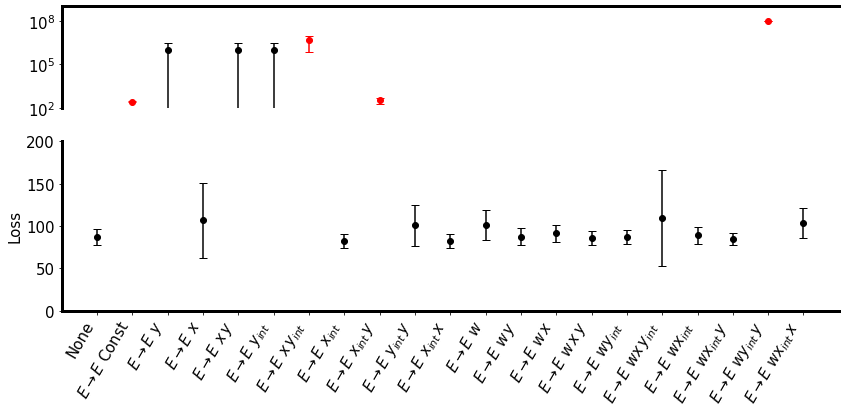

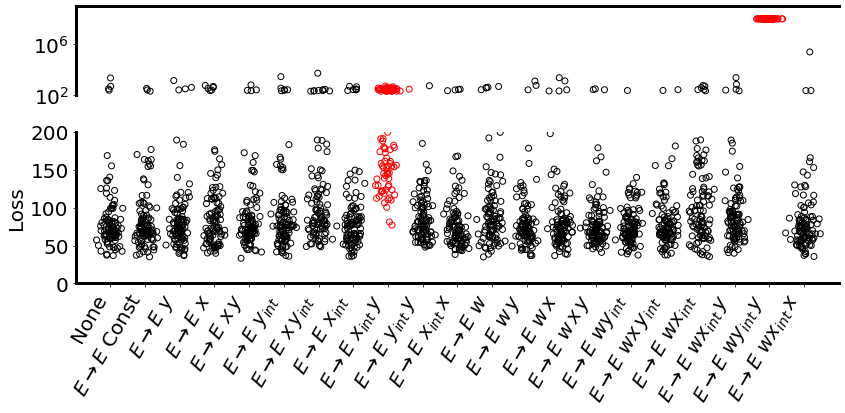

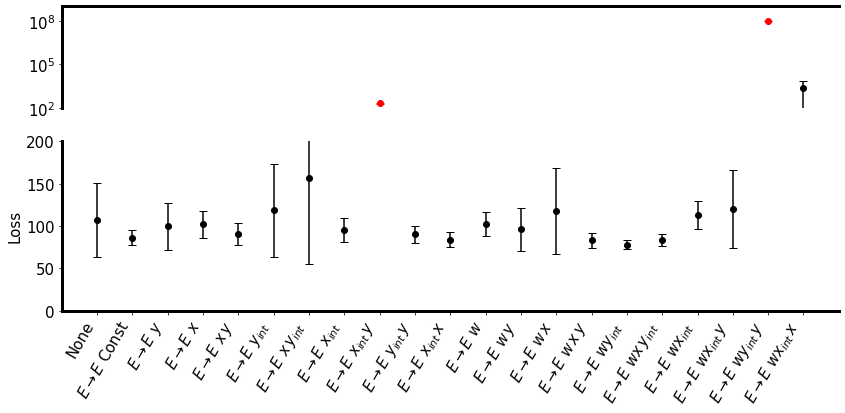

In [11]:
all_files = [
    'decoder_ee_rollback_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_500_2023-09-05_23:46:17.622618',
    'decoder_ee_rollback_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_500_2023-09-05_23:48:29.865431',
    'decoder_ee_rollback_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_500_2023-09-05_23:49:03.521933',
    'decoder_ee_rollback_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_500_2023-09-05_23:49:37.657592',
]

for file_name in all_files:
    load_best_avg_params(file_name, 20, 12, 1, 100, n_categories=1)

In [14]:
file_name = 'decoder_ee_rollback_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_500_2023-09-05_23:46:17.622618'
kl_divs = compute_kl_divs(file_name, 20, 12, 1, 100, n_categories=1)
write_path = f'./sims_out/{file_name}/rule_ranking.csv'

write_csv(write_path, [
    [],
    np.argsort(-kl_divs),
    kl_divs[np.argsort(-kl_divs)],
    [general_rule_names[i] for i in np.argsort(-kl_divs)]
])

In [15]:
file_name = 'decoder_ee_rollback_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_500_2023-09-05_23:48:29.865431'
kl_divs = compute_kl_divs(file_name, 20, 12, 1, 100, n_categories=1)
write_path = f'./sims_out/{file_name}/rule_ranking.csv'

write_csv(write_path, [
    [],
    np.argsort(-kl_divs),
    kl_divs[np.argsort(-kl_divs)],
    [general_rule_names[i] for i in np.argsort(-kl_divs)]
])

In [16]:
file_name = 'decoder_ee_rollback_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_500_2023-09-05_23:49:03.521933'
kl_divs = compute_kl_divs(file_name, 20, 12, 1, 100, n_categories=1)
write_path = f'./sims_out/{file_name}/rule_ranking.csv'

write_csv(write_path, [
    [],
    np.argsort(-kl_divs),
    kl_divs[np.argsort(-kl_divs)],
    [general_rule_names[i] for i in np.argsort(-kl_divs)]
])

In [17]:
file_name = 'decoder_ee_rollback_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_500_2023-09-05_23:49:37.657592'
kl_divs = compute_kl_divs(file_name, 20, 12, 1, 100, n_categories=1)
write_path = f'./sims_out/{file_name}/rule_ranking.csv'

write_csv(write_path, [
    [],
    np.argsort(-kl_divs),
    kl_divs[np.argsort(-kl_divs)],
    [general_rule_names[i] for i in np.argsort(-kl_divs)]
])

# Does the minimal model capture the performance of the full model?

814.0
930.0
913.0
797.0
870.0
947.0
896.0


Text(0.5, 0, 'No. terms included')

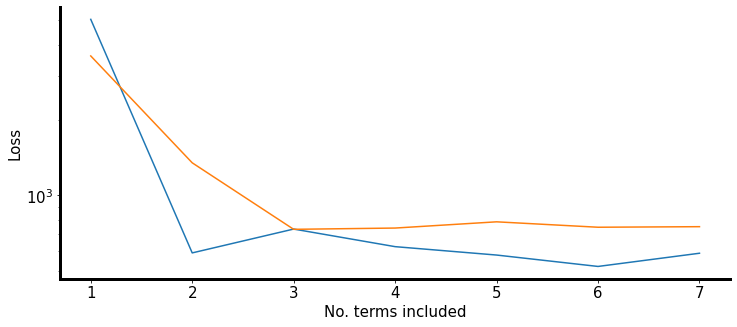

In [14]:
file_names = [
    'refit_ee_syn_ss_1_terms_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_503_2023-09-06_22:39:18.298247',
    'refit_ee_syn_ss_2_terms_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_503_2023-09-06_22:39:41.917329',
    'refit_ee_syn_ss_3_terms_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_503_2023-09-06_22:41:04.741016',
    'refit_ee_syn_ss_4_terms_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_503_2023-09-06_22:42:02.842726',
    'refit_ee_syn_ss_5_terms_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_503_2023-09-06_22:42:02.842713',
    'refit_ee_syn_ss_6_terms_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_503_2023-09-06_22:43:24.946294',
    'refit_ee_syn_ss_7_terms_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_503_2023-09-06_22:43:24.946342',
]

all_losses = []
all_losses_test = []
for f in file_names:
    min_loss, min_loss_test = fetch_minimum_loss(f, 20, 12, 10)
    all_losses.append(min_loss)
    all_losses_test.append(min_loss_test)

scale = 2
fig, axs = plt.subplots(1, 1, figsize=(6 * scale, 2.5 * scale))
format_axs(axs)

axs.plot(np.arange(1, 8), all_losses)
axs.plot(np.arange(1, 8), all_losses_test)
axs.set_yscale('log')
# axs.set_ylim(0, 3000)
axs.set_ylabel('Loss')
axs.set_xlabel('No. terms included')

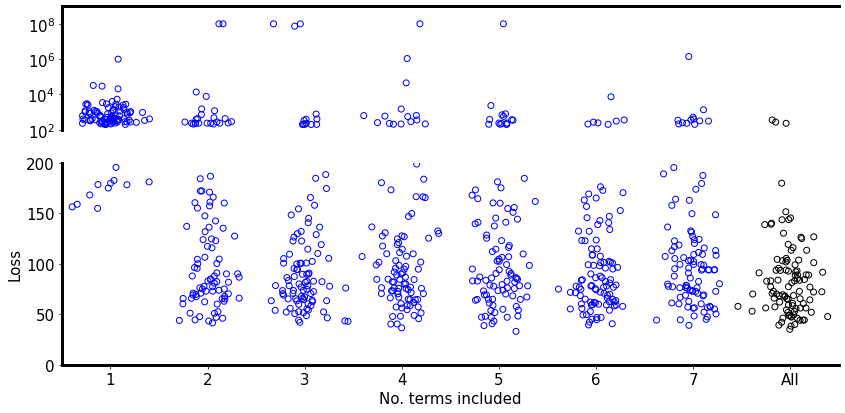

In [61]:
plot_elbo_curve(
    'refit_test_syn_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_600_2023-09-07_23:43:47.859754',
    20,
    12,
    1,
    100,
    n_categories=1,
    full_rules_file_name='decoder_ee_rollback_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_500_2023-09-05_23:49:03.521933',
)